# Poisson-Nernst-Planck systems & continuous2discrete 

*Johannes Hörmann, Lukas Elflein, 2019*

from continuous electrochemical double layer theory to discrete coordinate sets

In [1]:
# for dynamic module reload during testing, code modifications take immediate effect
%load_ext autoreload
%autoreload 2

In [2]:
# stretching notebook width across whole window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# basics
import logging
import numpy as np
import scipy.constants as sc
import matplotlib.pyplot as plt

In [4]:
# sampling
from scipy import interpolate
from matscipy.electrochemistry import continuous2discrete
from matscipy.electrochemistry import get_histogram
from matscipy.electrochemistry.utility import plot_dist

In [5]:
# electrochemistry basics
from matscipy.electrochemistry import debye, ionic_strength

In [6]:
# Poisson-Bolzmann distribution
from matscipy.electrochemistry.poisson_boltzmann_distribution import gamma, potential, concentration, charge_density

In [7]:
# Poisson-Nernst-Planck solver
from matscipy.electrochemistry import PoissonNernstPlanckSystem

In [8]:
# 3rd party file output
import ase
import ase.io

In [9]:
# PoissonNernstPlanckSystem makes extensive use of Python's logging module

# configure logging: verbosity level and format as desired
standard_loglevel   = logging.INFO
# standard_logformat  = ''.join(("%(asctime)s",
#  "[ %(filename)s:%(lineno)s - %(funcName)s() ]: %(message)s"))
standard_logformat  = "[ %(filename)s:%(lineno)s - %(funcName)s() ]: %(message)s"

# reset logger if previously loaded
logging.shutdown()
logging.basicConfig(level=standard_loglevel,
                    format=standard_logformat,
                    datefmt='%m-%d %H:%M')

# in Jupyter notebooks, explicitly modifying the root logger necessary
logger = logging.getLogger()
logger.setLevel(standard_loglevel)

# remove all handlers
for h in logger.handlers: logger.removeHandler(h)

# create and append custom handles
ch = logging.StreamHandler()
formatter = logging.Formatter(standard_logformat)
ch.setFormatter(formatter)
ch.setLevel(standard_loglevel)
logger.addHandler(ch)

In [10]:
# Test 1
logging.info("Root logger")

[ <ipython-input-10-adec08aea02d>:2 - <module>() ]: Root logger


In [11]:
# Test 2
logger.info("Root Logger")

[ <ipython-input-11-4335e316391c>:2 - <module>() ]: Root Logger


In [12]:
# Debug Test
logging.debug("Root logger")

In [13]:
# tiny helper for plotting
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

# General Poisson-Nernst-Planck System

For general systems, i.e. a nanogap between two electrodes with not necessarily binary electrolyte, no closed analytic solution exists.
Thus, we solve the full Poisson-Nernst-Planck system of equations. 

A binary Poisson-Nernst-Planck system corresponds to the transport problem in semiconductor physics.
In this context, Debye length, charge carrier densities and potential are related as follows.

## Excursus: Transport problem in PNP junction (German)

### Debye length

Woher kommt die Debye-Länge

$$ \lambda = \sqrt{ \frac{\varepsilon \varepsilon_0 k_B T}{q^2 n_i} }$$

als natürliche Längeneinheit des Transportptoblems?

Hier ist $n_i$ eine Referenzladungsträgerdichte, in der Regel die intrinsische Ladungsträgerdichte. 
In dem Beispiel mit $N^+NN^+$-dotiertem Halbleiter erzeugen wir durch unterschiedliches Doping an den Rändern die erhöhte Donatorendichte $N_D^+ = 10^{20} \mathrm{cm}^{-3}$ und im mitteleren Bereich "Standarddonatorendichte" $N_D = 10^{18} \mathrm{cm}^{-3}$. Nun können wir als Referenz $n_i = N_D$ wählen und die Donatorendichten als $N_D = 1 \cdot n_i$ und $N_D^+ = 100 \cdot n_i$ ausdrücken. Diese normierte Konzentration nennen wir einfach $\tilde{N}_D$: $N_D = \tilde{N}_D \cdot n_i$.

Ein ionisierter Donator trägt die Ladung $q$, ein Ladungsträger (in unserem Fall ein Elektron) trägt die Elementarladung $-q$. Die Raumladungsdichte $\rho$ in der Poissongleichung

$$ \nabla^2 \varphi = - \frac{\rho}{\varepsilon \varepsilon_0}$$

lässt sich also ganz einfach als $\rho = - (n - N_D) \cdot q = - (\tilde{n} - \tilde{N}_D) ~ n_i ~ q$ ausdrücken. 

Konventionell wird das Potential auf $u = \frac{\phi ~ q}{k_B ~ T}$ normiert. Die Poissongleichung nimmt damit die Form

$$\frac{k_B ~ T}{q} \cdot \nabla^2 u = \frac{(\tilde{n} - \tilde{N}_D) ~ n_i ~ q }{\varepsilon \varepsilon_0}$$

oder auch 

$$ \frac{\varepsilon ~ \varepsilon_0 ~ k_B ~ T}{q^2 n_i} \cdot \nabla^2 u = \lambda^2 \cdot \nabla^2 u = \tilde{n} - \tilde{N}_D$$



### Dimensionless formulation

Poisson- und Drift-Diffusionsgleichung

$$ 
\lambda^2 \frac{\partial^2 u}{\partial x^2} = n - N_D
$$

$$ 
\frac{\partial n}{\partial t} = - D_n \ \frac{\partial}{\partial x} \left( n \ \frac{\partial u}{\partial x} - \frac{\partial n}{\partial x} \right) + R
$$

Skaliert mit [l], [t]:

$$ 
\frac{\lambda^2}{[l]^2} \frac{\partial^2 u}{\partial \tilde{x}^2} = n - N
$$

und

$$ 
\frac{1}{[t]} \frac{\partial n}{\partial \tilde{t}} = - \frac{D_n}{[l]^2} \ \frac{\partial}{\partial x} \left( n \ \frac{\partial u}{\partial x} - \frac{\partial n}{\partial x} \right) + R 
$$

oder

$$ 
\frac{\partial n}{\partial \tilde{t}} = - \tilde{D}_n \ \frac{\partial}{\partial x} \left( n \ \frac{\partial u}{\partial x} - \frac{\partial n}{\partial x} \right) +  \tilde{R} 
$$

mit 

$$ 
\tilde{D}_n = D_n \frac{[t]}{[l]^2} \Leftrightarrow [t] = [l]^2 \ \frac{ \tilde{D}_n } { D_n } 
$$
    
und

$$ \tilde{R} = \frac{n - N_D}{\tilde{\tau}}$$ 

mit $\tilde{\tau} = \tau / [t]$. 

$\tilde{\lambda} = 1$ und $\tilde{D_n} = 1$ werden mit
$[l] = \lambda$ und $[t] = \frac{\lambda^2}{D_n}$ erreicht:

### Discretization

Naive Diskretisierung (skaliert):

$$ \frac{1}{\Delta x^2} ( u_{i+1}-2u_i+u_{i-1} ) = n_i - N_i $$

$$ \frac{1}{\Delta t} ( n_{i,j+1} - n_{i,j} ) = - \frac{1}{\Delta x^2} \cdot \left[ \frac{1}{4} (n_{i+1} - n_{i-1}) (u_{i+1} - u_{i-1}) + n_i ( u_{i+1} - 2 u_i + u_{i-1} ) - ( n_{i+1} - 2 n_i + n_{i-1} ) \right] + \frac{ n_i - N_i}{ \tilde{\tau} } $$

Stationär:

$$
 u_{i+1}-2u_i+u_{i-1} - \Delta x^2 \cdot n_i + \Delta x^2 \cdot N_i = 0
$$

und

$$
  \frac{1}{4} (n_{i+1} - n_{i-1}) (u_{i+1} - u_{i-1}) + n_i ( u_{i+1} - 2 u_i + u_{i-1} ) - ( n_{i+1} - 2 n_i + n_{i-1} ) - \Delta x^2 \cdot \frac{ n_i - N_i}{ \tilde{\tau} } = 0
$$

### Newton-Iteration für gekoppeltes nicht-lineares Gleichungssystem

Idee: Löse nicht-lineares Finite-Differenzen-Gleichungssystem über Newton-Verfahren  

$$ \vec{F}(\vec{x}_{k+1}) = F(\vec{x}_k + \Delta \vec{x}_k) \approx F(\vec{x}_k) + \mathbf{J_F}(\vec{x}_k) \cdot \Delta \vec{x}_k + \mathcal{O}(\Delta x^2)$$
   
mit Unbekannter $\vec{x_k} = \{u_1^k, \dots, u_N^k, n_1^k, \dots, n_N^k\}$  und damit

$$ \Rightarrow \Delta \vec{x}_k = - \mathbf{J}_F^{-1} ~ F(\vec{x}_k)$$

wobei die Jacobi-Matrix $2N \times 2N$ Einträge

$$ \mathbf{J}_{ij}(\vec{x}_k) = \frac{\partial F_i}{\partial x_j} (\vec{x}_k) $$

besitzt, die bei jedem Iterationsschritt für $\vec{x}_k$ ausgewertet werden.
Der tatsächliche Aufwand liegt in der Invertierung der Jacobi-Matrix, um in jeder Iteration $k$ den Korrekturschritt $\Delta \vec{x}_k$ zu finden.m

$F(x)$ wird wie unten definiert als:

$$
 u_{i+1}-2u_i+u_{i-1} - \Delta x^2 \cdot n_i + \Delta x^2 \cdot N_i = 0
$$

und

$$
  \frac{1}{4} (n_{i+1} - n_{i-1}) (u_{i+1} - u_{i-1}) + n_i ( u_{i+1} - 2 u_i + u_{i-1} ) - ( n_{i+1} - 2 n_i + n_{i-1} ) - \Delta x^2 \cdot \frac{ n_i - N_i}{ \tilde{\tau} } = 0
$$

### Controlled-Volume

Drücke nicht-linearen Teil der Transportgleichung (genauer, des Flusses) über Bernoulli-Funktionen 

$$ B(x) = \frac{x}{\exp(x)-1} $$ 

aus (siehe Vorlesungsskript). Damit wir in der Nähe von 0 nicht "in die Bredouille geraten", verwenden wir hier lieber die Taylorentwicklung. In der Literatur (Selbherr, S. Analysis and Simulation of Semiconductor Devices, Spriger 1984) wird eine noch aufwendigere stückweise Definition empfohlen, allerdings werden wir im Folgenden sehen, dass unser Ansatz für dieses stationäre Problem genügt.


## Implementation for Poisson-Nernst-Planck system

Poisson-Nernst-Planck system for $k = {1 \dots M}$ ion species in dimensionless formulation

$$ \nabla^2 u + \rho(n_{1},\dots,n_{M}) = 0 $$

$$ \nabla^2 n_k + \nabla ( z_k n_k \nabla u ) = 0 \quad \text{for} \quad k = 1 \dots M $$

yields a naive finite difference discretization on $i = {1 \dots N}$ grid points for $k = {1 \dots M}$ ion species

$$ \frac{1}{\Delta x^2} ( u_{i+1}-2u_i+u_{i-1} )  + \frac{1}{2} \sum_{k=1}^M z_k n_{i,k} = 0 $$

$$ - \frac{1}{\Delta x^2} \cdot \left[ \frac{1}{4} z_k (n_{i+1,k} - n_{i-1,k}) (u_{i+1} - u_{i-1}) + z_k n_{i,k} ( u_{i+1} - 2 u_i + u_{i-1} ) + ( n_{i+1,k} - 2 n_{i,k} + n_{i-1,k} ) \right] $$

or rearranged

$$ u_{i+1}-2 u_i+u_{i-1} + \Delta x^2 \frac{1}{2} \sum_{k=1}^M z_k n_{i,k}  = 0 $$

and

$$
  \frac{1}{4} z_k (n_{i+1,k} - n_{i-1,k}) (u_{i+1,k} - u_{i-1,k}) + z_k n_{i,k} ( u_{i+1} - 2 u_i + u_{i-1} ) - ( n_{i+1,k} - 2 n_{i,k} + n_{i-1,k} ) = 0
$$

### Controlled Volumes, 1D

Finite differences do not converge in our non-linear systems. Instead, we express non-linear part of the Nernts-Planck equations with Bernoulli function (Selberherr, S. Analysis and Simulation of Semiconductor Devices, Spriger 1984)

$$ B(x) = \frac{x}{\exp(x)-1} $$ 

In [14]:
def B(x):
    return np.where( np.abs(x) < 1e-9,
        1 - x/2 + x**2/12 - x**4/720, # Taylor
        x / ( np.exp(x) - 1 ) )

In [15]:
xB = np.arange(-10,10,0.1)

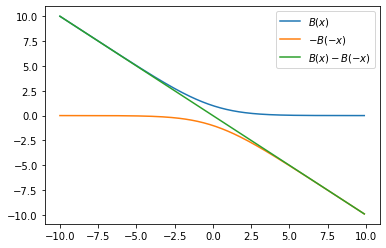

In [16]:
plt.plot( xB ,B( xB ), label="$B(x)$")
plt.plot( xB, - B(-xB), label="$-B(-x)$")
plt.plot( xB, B(xB)-B(-xB), label="$B(x)-B(-x)$")
plt.legend()

Looking at (dimensionless) flux $j_k$ throgh segment $k$ in between grid points $i$ and $j$,

$$ j_k = - \frac{dn}{dx} - z n \frac{du}{dx} $$

for an ion species with number charge $z$ and (dimensionless) concentration $n$, 
we assume (dimensionless) potential $u$ to behave linearly within this segment. The linear expression

$$ u = \frac{u_j - u_i}{L_k} \cdot \xi_k + u_i = a_k \xi_k + u_i $$ 

with the segment's length $L_k = \Delta x$ for uniform discretization, $\xi_k = x - x_i$ and proportionality factor $a_k = \frac{u_j - u_i}{L_k}$ leadsd to a flux

$$ j_k = - \frac{dn}{d\xi} - z a_k n  $$

solvable for $v$ via

$$ \frac{dn}{d\xi} = - z a_k n - j_k $$

or 

$$ \frac{dn}{z a_k n + j_k} = - d\xi \text{.} $$

We intergate from grid point $i$ to $j$

$$ \int_{n_i}^{n_j} \frac{1}{z a_k n + j_k} dn = - L_k $$

and find

$$ \frac{1}{(z a_k)} \left[ \ln(j_k + z a_k n) \right]_{n_i}^{n^j} = - L_k $$

or

$$ \ln(j_k + z a_k n_j) - \ln(j_k + z a_k n_i) = - z a_k L_k $$

which we solve for $j_k$ by rearranging

$$ \frac{j_k + z a_k n_j}{j_k + z a_k n_i} = e^{- z a_k L_k} $$

$$ j_k + z a_k n_j = (j_k + z a_k n_i) e^{- z a_k L_k} $$

$$ j_k ( 1 - e^{- z a_k L_k} ) = - z a_k n_j  +  z a_k n_i e^{- z a_k L_k} $$

$$j_k = \frac{z a_k n_j}{e^{- z a_k L_k} - 1}  +  \frac{ z a_k n_i e^{- z a_k L_k}}{ 1 - e^{- z a_k L_k}}$$

$$j_k = \frac{1}{L_k} \cdot \left[ \frac{z a_k L_k n_j}{e^{- z a_k L_k} - 1}  +  \frac{ z a_k L_k n_i }{ e^{z a_k L_k} - 1} \right] $$

or with $B(x) = \frac{x}{e^x-1}$ expressed as

$$j_k = \frac{1}{L_k} \cdot \left[ - n_j B( - z a_k L_k ) +  n_i B( z a_k L_k) \right] $$

and resubstituting $a_k = \frac{u_j - u_i}{L_k}$ as

$$j_k = - \frac{1}{L_k} \cdot \left[ n_j B( z [u_i - u_j] ) - n_i B( z [u_j - u_i] ) \right] \ \text{.}$$

When employing our 1D uniform grid with $j_k = j_{k-1}$ for all $k = 1 \dots N$,

$$ j_k \Delta x  = n_{i+1} B( z [u_i - u_{i+1}] ) - n_i B( z [u_{i+1} - u_i] ) $$

and

$$ j_{k-1} \Delta x  = n_i B( z [u_{i-1} - u_i] ) - n_{i-1} B( z [u_i - u_{i-1}] ) $$

require

$$ n_{i+1} B( z [u_i - u_{i+1}] ) - n_i \left( B( z [u_{i+1} - u_i] ) + B( z [u_{i-1} - u_i] ) \right) + n_{i-1} B( z [u_i - u_{i-1}] ) = 0 $$

## Test case 1: PNP interface system, 0.1 mM NaCl, positive potential u = 0.05 V

In [17]:
# Test case parameters
c=[0.1, 0.1]
z=[ 1, -1] 
L=1e-07
delta_u=0.05

In [18]:
# define desired system
pnp = PoissonNernstPlanckSystem(c, z, L, delta_u=delta_u)
# constructor takes keyword arguments
#   c=array([0.1, 0.1]), z=array([ 1, -1]), L=1e-07, T=298.15, delta_u=0.05, relative_permittivity=79, vacuum_permittivity=8.854187817620389e-12, R=8.3144598, F=96485.33289
# with default values set for 0.1 mM NaCl aqueous solution across 100 nm  and 0.05 V potential drop

[ poisson_nernst_planck_solver.py:1004 - __init__() ]: ion species 00 concentration c                0.1
[ poisson_nernst_planck_solver.py:1006 - __init__() ]: ion species 00 number charge z                  1
[ poisson_nernst_planck_solver.py:1004 - __init__() ]: ion species 01 concentration c                0.1
[ poisson_nernst_planck_solver.py:1006 - __init__() ]: ion species 01 number charge z                 -1
[ poisson_nernst_planck_solver.py:1009 - __init__() ]: temperature T                               298.1
[ poisson_nernst_planck_solver.py:1011 - __init__() ]: domain size L                               1e-07
[ poisson_nernst_planck_solver.py:1013 - __init__() ]: compact layer thickness lambda_S                0
[ poisson_nernst_planck_solver.py:1015 - __init__() ]: reference position x0                           0
[ poisson_nernst_planck_solver.py:1017 - __init__() ]: potential difference delta_u                 0.05
[ poisson_nernst_planck_solver.py:1019 - __init__() ]: 

In [19]:
pnp.useStandardInterfaceBC()

[ poisson_nernst_planck_solver.py:374 - useStandardInterfaceBC() ]: Left hand side Dirichlet boundary condition:                               u0 =    1.946
[ poisson_nernst_planck_solver.py:375 - useStandardInterfaceBC() ]: Right hand side Dirichlet boundary condition:                              u1 =        0
[ poisson_nernst_planck_solver.py:384 - useStandardInterfaceBC() ]: Ion species 00 left hand side concentration Flux boundary condition:       j0 =        0
[ poisson_nernst_planck_solver.py:385 - useStandardInterfaceBC() ]: Ion species 00 right hand side concentration Dirichlet boundary condition: c1 =        1
[ poisson_nernst_planck_solver.py:384 - useStandardInterfaceBC() ]: Ion species 01 left hand side concentration Flux boundary condition:       j0 =        0
[ poisson_nernst_planck_solver.py:385 - useStandardInterfaceBC() ]: Ion species 01 right hand side concentration Dirichlet boundary condition: c1 =        1


In [20]:
pnp.init()

[ poisson_nernst_planck_solver.py:269 - init() ]: discretization segments N                     200
[ poisson_nernst_planck_solver.py:271 - init() ]: grid points N                                 201
[ poisson_nernst_planck_solver.py:286 - init() ]: dx                                        0.01638
[ poisson_nernst_planck_solver.py:288 - init() ]: dx2overtau                                     10


In [21]:
pnp.output = True # let's Newton solver display convergence plots
uij, nij, lamj = pnp.solve()

[ poisson_nernst_planck_solver.py:166 - newton() ]: Convergence criterion: norm(dx) < 1.00e-10
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    0: norm(dx)/norm(x) = 8.30e-01, norm(dx) = 2.13e+01, norm(F) = 1.38e-02
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    1: norm(dx)/norm(x) = 1.79e-01, norm(dx) = 6.04e+00, norm(F) = 1.00e-01
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    2: norm(dx)/norm(x) = 4.56e-04, norm(dx) = 1.66e-02, norm(F) = 3.64e-03
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    3: norm(dx)/norm(x) = 6.17e-09, norm(dx) = 2.25e-07, norm(F) = 3.81e-08
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    4: norm(dx)/norm(x) = 5.44e-14, norm(dx) = 1.98e-12, norm(F) = 7.09e-13
[ poisson_nernst_planck_solver.py:238 - newton() ]: Ended after 5 steps.


### Validation: Analytical half-space solution & Numerical finite-size PNP system

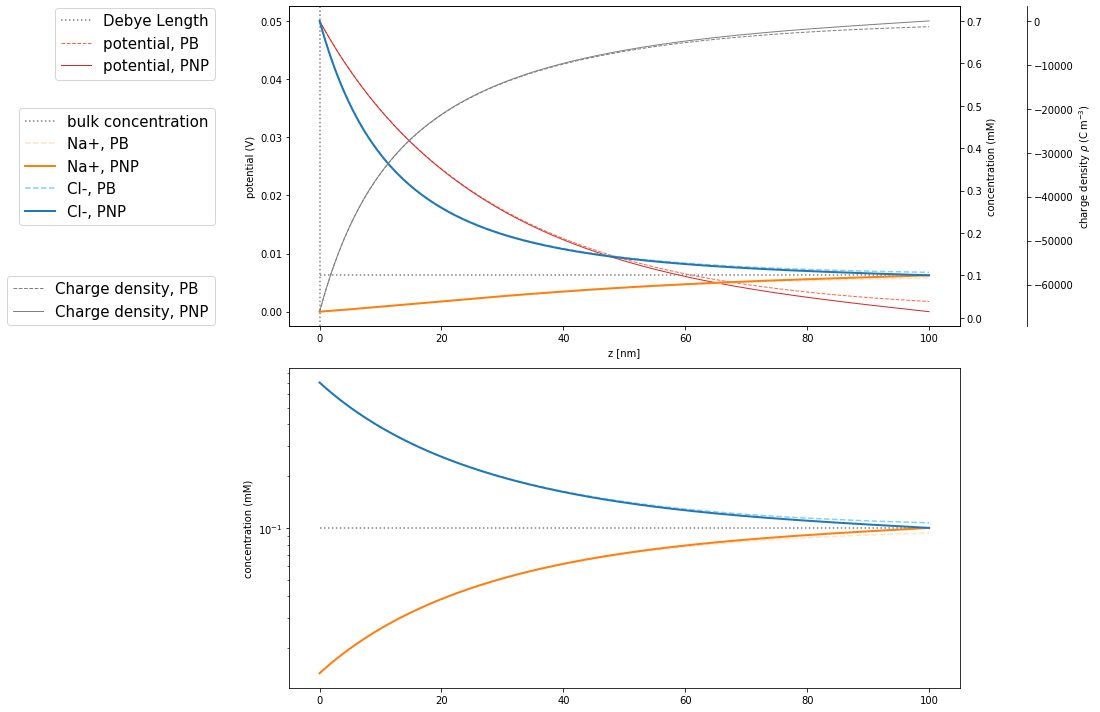

In [22]:
# analytic Poisson-Boltzmann distribution and numerical solution to full Poisson-Nernst-Planck system
x = np.linspace(0,L,100)
phi = potential(x, c, z, delta_u) 
C =   concentration(x, c, z, delta_u)
rho = charge_density(x, c, z, delta_u) 
deb = debye(c, z)

fig, (ax1,ax4) = plt.subplots(nrows=2,ncols=1,figsize=[16,10])
ax1.axvline(x=deb, label='Debye Length', color='grey', linestyle=':')

ax1.plot(x/sc.nano, phi, marker='', color='tomato', label='potential, PB', linewidth=1, linestyle='--')
ax1.plot(pnp.grid/sc.nano, pnp.potential, marker='', color='tab:red', label='potential, PNP', linewidth=1, linestyle='-')

ax2 = ax1.twinx()
ax2.plot(x/sc.nano, np.ones(x.shape)*c[0], label='bulk concentration', color='grey', linestyle=':')
ax2.plot(x/sc.nano, C[0], marker='', color='bisque', label='Na+, PB',linestyle='--')
ax2.plot(pnp.grid/sc.nano, pnp.concentration[0], marker='', color='tab:orange', label='Na+, PNP', linewidth=2, linestyle='-')

ax2.plot(x/sc.nano, C[1], marker='', color='lightskyblue', label='Cl-, PB',linestyle='--')
ax2.plot(pnp.grid/sc.nano, pnp.concentration[1], marker='', color='tab:blue', label='Cl-, PNP', linewidth=2, linestyle='-')

ax3 = ax1.twinx()
# Offset the right spine of ax3.  The ticks and label have already been
# placed on the right by twinx above.
ax3.spines["right"].set_position(("axes", 1.1))
# Having been created by twinx, ax3 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(ax3)
# Second, show the right spine.
ax3.spines["right"].set_visible(True)

ax3.plot(x/sc.nano, rho, label='Charge density, PB', color='grey', linewidth=1, linestyle='--')
ax3.plot(pnp.grid/sc.nano, pnp.charge_density, label='Charge density, PNP', color='grey', linewidth=1, linestyle='-')

ax4.semilogy(x/sc.nano, np.ones(x.shape)*c[0], label='bulk concentration', color='grey', linestyle=':')
ax4.semilogy(x/sc.nano, C[0], marker='', color='bisque', label='Na+, PB',linestyle='--')
ax4.semilogy(pnp.grid/sc.nano, pnp.concentration[0], marker='', color='tab:orange', label='Na+, PNP', linewidth=2, linestyle='-')

ax4.semilogy(x/sc.nano, C[1], marker='', color='lightskyblue', label='Cl-, PB',linestyle='--')
ax4.semilogy(pnp.grid/sc.nano, pnp.concentration[1], marker='', color='tab:blue', label='Cl-, PNP', linewidth=2, linestyle='-')


ax1.set_xlabel('z [nm]')
ax1.set_ylabel('potential (V)')
ax2.set_ylabel('concentration (mM)')
ax3.set_ylabel(r'charge density $\rho \> (\mathrm{C}\> \mathrm{m}^{-3})$')
ax4.set_ylabel('concentration (mM)')

#fig.legend(loc='center')
ax1.legend(loc='upper right',  bbox_to_anchor=(-0.1,1.02), fontsize=15)
ax2.legend(loc='center right', bbox_to_anchor=(-0.1,0.5),  fontsize=15)
ax3.legend(loc='lower right',  bbox_to_anchor=(-0.1,-0.02), fontsize=15)

fig.tight_layout()
plt.show()

#### Potential at left and right hand side of domain

In [23]:
(pnp.potential[0],pnp.potential[-1])

(0.05, 1.0002377843883616e-30)

#### Residual cation flux at interface and at open right hand side

In [24]:
( pnp.leftControlledVolumeSchemeFluxBC(pnp.xij1,0), pnp.rightControlledVolumeSchemeFluxBC(pnp.xij1,0) )

(-1.942890293094024e-16, 4.651834473179406e-14)

#### Residual anion flux at interface and at open right hand side

In [25]:
(pnp.leftControlledVolumeSchemeFluxBC(pnp.xij1,1),  pnp.rightControlledVolumeSchemeFluxBC(pnp.xij1,0) )

(7.993605777301127e-15, 4.651834473179406e-14)

#### Cation concentration at interface and at open right hand side

In [26]:
(pnp.concentration[0,0],pnp.concentration[0,-1])

(0.014283184856458506, 0.1)

#### Anion concentration at interface and at open right hand side

In [27]:
(pnp.concentration[1,0],pnp.concentration[1,-1])

(0.7001239639826025, 0.1)

## Test case 2: PNP interface system, 0.1 mM NaCl, negative potential u = -0.05 V, analytical solution as initial values

In [28]:
# Test case parameters
c=[0.1, 0.1]
z=[ 1, -1] 
L=1e-07
delta_u=-0.05

In [29]:
pnp = PoissonNernstPlanckSystem(c, z, L, delta_u=delta_u)

[ poisson_nernst_planck_solver.py:1004 - __init__() ]: ion species 00 concentration c                0.1
[ poisson_nernst_planck_solver.py:1006 - __init__() ]: ion species 00 number charge z                  1
[ poisson_nernst_planck_solver.py:1004 - __init__() ]: ion species 01 concentration c                0.1
[ poisson_nernst_planck_solver.py:1006 - __init__() ]: ion species 01 number charge z                 -1
[ poisson_nernst_planck_solver.py:1009 - __init__() ]: temperature T                               298.1
[ poisson_nernst_planck_solver.py:1011 - __init__() ]: domain size L                               1e-07
[ poisson_nernst_planck_solver.py:1013 - __init__() ]: compact layer thickness lambda_S                0
[ poisson_nernst_planck_solver.py:1015 - __init__() ]: reference position x0                           0
[ poisson_nernst_planck_solver.py:1017 - __init__() ]: potential difference delta_u                -0.05
[ poisson_nernst_planck_solver.py:1019 - __init__() ]: 

In [30]:
pnp.useStandardInterfaceBC()

[ poisson_nernst_planck_solver.py:374 - useStandardInterfaceBC() ]: Left hand side Dirichlet boundary condition:                               u0 =   -1.946
[ poisson_nernst_planck_solver.py:375 - useStandardInterfaceBC() ]: Right hand side Dirichlet boundary condition:                              u1 =        0
[ poisson_nernst_planck_solver.py:384 - useStandardInterfaceBC() ]: Ion species 00 left hand side concentration Flux boundary condition:       j0 =        0
[ poisson_nernst_planck_solver.py:385 - useStandardInterfaceBC() ]: Ion species 00 right hand side concentration Dirichlet boundary condition: c1 =        1
[ poisson_nernst_planck_solver.py:384 - useStandardInterfaceBC() ]: Ion species 01 left hand side concentration Flux boundary condition:       j0 =        0
[ poisson_nernst_planck_solver.py:385 - useStandardInterfaceBC() ]: Ion species 01 right hand side concentration Dirichlet boundary condition: c1 =        1


In [31]:
pnp.init()

[ poisson_nernst_planck_solver.py:269 - init() ]: discretization segments N                     200
[ poisson_nernst_planck_solver.py:271 - init() ]: grid points N                                 201
[ poisson_nernst_planck_solver.py:286 - init() ]: dx                                        0.01638
[ poisson_nernst_planck_solver.py:288 - init() ]: dx2overtau                                     10


In [32]:
# initial config
x = np.linspace(0, pnp.L, pnp.Ni)
phi = potential(x, c, z, delta_u) 
C = concentration(x, c, z, delta_u)

In [33]:
pnp.ni0 = C / pnp.c_unit # manually remove dimensions from analyatical solution

In [34]:
ui0 = pnp.initial_values()

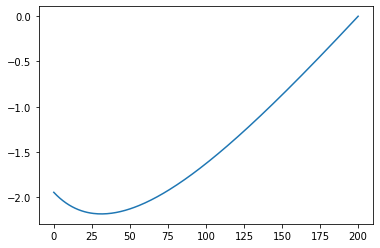

In [35]:
plt.plot(ui0) # solution to linear Poisson equation under assumption of fixed charge density distribution

In [36]:
pnp.output = True # let's Newton solver display convergence plots
uij, nij, lamj = pnp.solve() # no faster convergence than above, compare convergence plots for test case 1

[ poisson_nernst_planck_solver.py:166 - newton() ]: Convergence criterion: norm(dx) < 1.00e-10
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    0: norm(dx)/norm(x) = 3.36e-01, norm(dx) = 1.40e+01, norm(F) = 3.91e-01
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    1: norm(dx)/norm(x) = 3.95e-02, norm(dx) = 1.39e+00, norm(F) = 1.11e-02
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    2: norm(dx)/norm(x) = 3.05e-04, norm(dx) = 1.11e-02, norm(F) = 2.33e-04
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    3: norm(dx)/norm(x) = 5.33e-08, norm(dx) = 1.94e-06, norm(F) = 4.12e-08
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    4: norm(dx)/norm(x) = 1.41e-13, norm(dx) = 5.14e-12, norm(F) = 1.31e-12
[ poisson_nernst_planck_solver.py:238 - newton() ]: Ended after 5 steps.


### Validation: Analytical half-space solution & Numerical finite-size PNP system

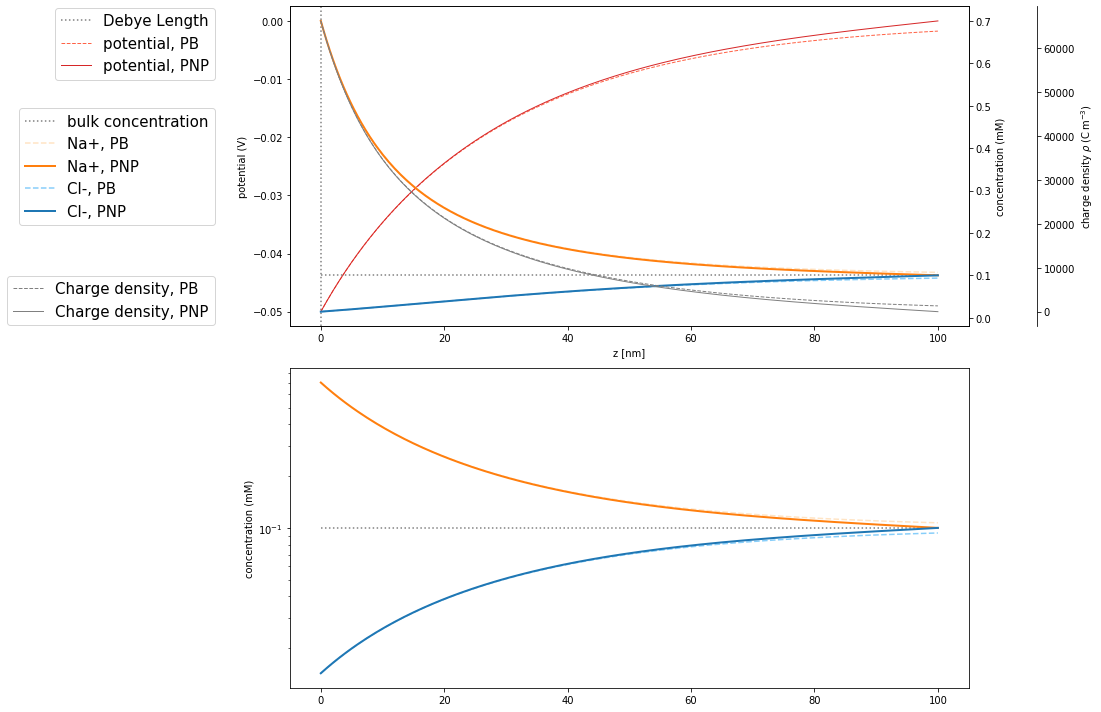

In [37]:
# analytic Poisson-Boltzmann distribution and numerical solution to full Poisson-Nernst-Planck system
x = np.linspace(0,L,100)
phi = potential(x, c, z, delta_u) 
C =   concentration(x, c, z, delta_u)
rho = charge_density(x, c, z, delta_u) 
deb = debye(c, z)

fig, (ax1,ax4) = plt.subplots(nrows=2,ncols=1,figsize=[16,10])
ax1.axvline(x=deb, label='Debye Length', color='grey', linestyle=':')

ax1.plot(x/sc.nano, phi, marker='', color='tomato', label='potential, PB', linewidth=1, linestyle='--')
ax1.plot(pnp.grid/sc.nano, pnp.potential, marker='', color='tab:red', label='potential, PNP', linewidth=1, linestyle='-')

ax2 = ax1.twinx()
ax2.plot(x/sc.nano, np.ones(x.shape)*c[0], label='bulk concentration', color='grey', linestyle=':')
ax2.plot(x/sc.nano, C[0], marker='', color='bisque', label='Na+, PB',linestyle='--')
ax2.plot(pnp.grid/sc.nano, pnp.concentration[0], marker='', color='tab:orange', label='Na+, PNP', linewidth=2, linestyle='-')

ax2.plot(x/sc.nano, C[1], marker='', color='lightskyblue', label='Cl-, PB',linestyle='--')
ax2.plot(pnp.grid/sc.nano, pnp.concentration[1], marker='', color='tab:blue', label='Cl-, PNP', linewidth=2, linestyle='-')

ax3 = ax1.twinx()
# Offset the right spine of ax3.  The ticks and label have already been
# placed on the right by twinx above.
ax3.spines["right"].set_position(("axes", 1.1))
# Having been created by twinx, ax3 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(ax3)
# Second, show the right spine.
ax3.spines["right"].set_visible(True)

ax3.plot(x/sc.nano, rho, label='Charge density, PB', color='grey', linewidth=1, linestyle='--')
ax3.plot(pnp.grid/sc.nano, pnp.charge_density, label='Charge density, PNP', color='grey', linewidth=1, linestyle='-')

ax4.semilogy(x/sc.nano, np.ones(x.shape)*c[0], label='bulk concentration', color='grey', linestyle=':')
ax4.semilogy(x/sc.nano, C[0], marker='', color='bisque', label='Na+, PB',linestyle='--')
ax4.semilogy(pnp.grid/sc.nano, pnp.concentration[0], marker='', color='tab:orange', label='Na+, PNP', linewidth=2, linestyle='-')

ax4.semilogy(x/sc.nano, C[1], marker='', color='lightskyblue', label='Cl-, PB',linestyle='--')
ax4.semilogy(pnp.grid/sc.nano, pnp.concentration[1], marker='', color='tab:blue', label='Cl-, PNP', linewidth=2, linestyle='-')


ax1.set_xlabel('z [nm]')
ax1.set_ylabel('potential (V)')
ax2.set_ylabel('concentration (mM)')
ax3.set_ylabel(r'charge density $\rho \> (\mathrm{C}\> \mathrm{m}^{-3})$')
ax4.set_ylabel('concentration (mM)')

#fig.legend(loc='center')
ax1.legend(loc='upper right',  bbox_to_anchor=(-0.1,1.02), fontsize=15)
ax2.legend(loc='center right', bbox_to_anchor=(-0.1,0.5),  fontsize=15)
ax3.legend(loc='lower right',  bbox_to_anchor=(-0.1,-0.02), fontsize=15)

fig.tight_layout()
plt.show()

#### Potential at left and right hand side of domain

In [38]:
(pnp.potential[0],pnp.potential[-1])

(-0.05, 1.8461062491369554e-30)

#### Residual cation flux at interface and at open right hand side

In [39]:
( pnp.leftControlledVolumeSchemeFluxBC(pnp.xij1,0), pnp.rightControlledVolumeSchemeFluxBC(pnp.xij1,0) )

(2.930988785010413e-14, 5.906386491005833e-14)

#### Residual anion flux at interface and at open right hand side

In [40]:
( pnp.leftControlledVolumeSchemeFluxBC(pnp.xij1,1), pnp.rightControlledVolumeSchemeFluxBC(pnp.xij1,1) )

(-6.38378239159465e-16, -5.939693181744587e-14)

#### Cation concentration at interface and at open right hand side

In [41]:
(pnp.concentration[0,0],pnp.concentration[0,-1])

(0.7001239639824193, 0.1)

#### Anion concentration at interface and at open right hand side

In [42]:
(pnp.concentration[1,0],pnp.concentration[1,-1])

(0.014283184856462594, 0.1)

## Test case 3: PNP interface system, 0.1 mM NaCl, positive potential u = 0.05 V, 200 nm domain

In [43]:
# Test case parameters
c=[0.1, 0.1]
z=[ 1, -1] 
L=2e-07
delta_u=0.05

In [44]:
pnp = PoissonNernstPlanckSystem(c, z, L, delta_u=delta_u)

[ poisson_nernst_planck_solver.py:1004 - __init__() ]: ion species 00 concentration c                0.1
[ poisson_nernst_planck_solver.py:1006 - __init__() ]: ion species 00 number charge z                  1
[ poisson_nernst_planck_solver.py:1004 - __init__() ]: ion species 01 concentration c                0.1
[ poisson_nernst_planck_solver.py:1006 - __init__() ]: ion species 01 number charge z                 -1
[ poisson_nernst_planck_solver.py:1009 - __init__() ]: temperature T                               298.1
[ poisson_nernst_planck_solver.py:1011 - __init__() ]: domain size L                               2e-07
[ poisson_nernst_planck_solver.py:1013 - __init__() ]: compact layer thickness lambda_S                0
[ poisson_nernst_planck_solver.py:1015 - __init__() ]: reference position x0                           0
[ poisson_nernst_planck_solver.py:1017 - __init__() ]: potential difference delta_u                 0.05
[ poisson_nernst_planck_solver.py:1019 - __init__() ]: 

In [45]:
pnp.useStandardInterfaceBC()

[ poisson_nernst_planck_solver.py:374 - useStandardInterfaceBC() ]: Left hand side Dirichlet boundary condition:                               u0 =    1.946
[ poisson_nernst_planck_solver.py:375 - useStandardInterfaceBC() ]: Right hand side Dirichlet boundary condition:                              u1 =        0
[ poisson_nernst_planck_solver.py:384 - useStandardInterfaceBC() ]: Ion species 00 left hand side concentration Flux boundary condition:       j0 =        0
[ poisson_nernst_planck_solver.py:385 - useStandardInterfaceBC() ]: Ion species 00 right hand side concentration Dirichlet boundary condition: c1 =        1
[ poisson_nernst_planck_solver.py:384 - useStandardInterfaceBC() ]: Ion species 01 left hand side concentration Flux boundary condition:       j0 =        0
[ poisson_nernst_planck_solver.py:385 - useStandardInterfaceBC() ]: Ion species 01 right hand side concentration Dirichlet boundary condition: c1 =        1


In [46]:
pnp.init()

[ poisson_nernst_planck_solver.py:269 - init() ]: discretization segments N                     200
[ poisson_nernst_planck_solver.py:271 - init() ]: grid points N                                 201
[ poisson_nernst_planck_solver.py:286 - init() ]: dx                                        0.03277
[ poisson_nernst_planck_solver.py:288 - init() ]: dx2overtau                                     10


In [47]:
pnp.output = True
uij, nij, lamj = pnp.solve()

[ poisson_nernst_planck_solver.py:166 - newton() ]: Convergence criterion: norm(dx) < 1.00e-10
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    0: norm(dx)/norm(x) = 6.35e-01, norm(dx) = 1.63e+01, norm(F) = 1.38e-02
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    1: norm(dx)/norm(x) = 2.72e-01, norm(dx) = 7.08e+00, norm(F) = 1.73e-01
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    2: norm(dx)/norm(x) = 3.95e-03, norm(dx) = 1.17e-01, norm(F) = 2.35e-02
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    3: norm(dx)/norm(x) = 3.58e-07, norm(dx) = 1.06e-05, norm(F) = 7.51e-06
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    4: norm(dx)/norm(x) = 3.76e-11, norm(dx) = 1.12e-09, norm(F) = 5.14e-10
[ poisson_nernst_planck_solver.py:238 - newton() ]: Ended after 5 steps.


### Validation: Analytical half-space solution & Numerical finite-size PNP system

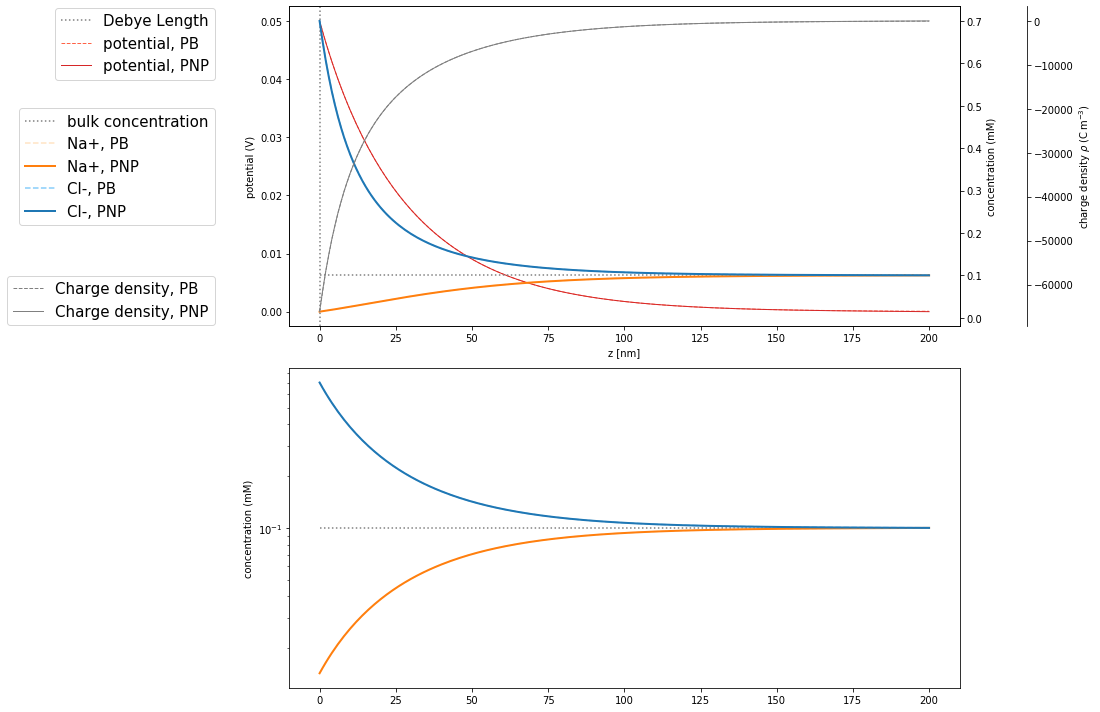

In [48]:
# analytic Poisson-Boltzmann distribution and numerical solution to full Poisson-Nernst-Planck system
x = np.linspace(0,L,100)
phi = potential(x, c, z, delta_u) 
C =   concentration(x, c, z, delta_u)
rho = charge_density(x, c, z, delta_u) 
deb = debye(c, z)

fig, (ax1,ax4) = plt.subplots(nrows=2,ncols=1,figsize=[16,10])
ax1.axvline(x=deb, label='Debye Length', color='grey', linestyle=':')

ax1.plot(x/sc.nano, phi, marker='', color='tomato', label='potential, PB', linewidth=1, linestyle='--')
ax1.plot(pnp.grid/sc.nano, pnp.potential, marker='', color='tab:red', label='potential, PNP', linewidth=1, linestyle='-')

ax2 = ax1.twinx()
ax2.plot(x/sc.nano, np.ones(x.shape)*c[0], label='bulk concentration', color='grey', linestyle=':')
ax2.plot(x/sc.nano, C[0], marker='', color='bisque', label='Na+, PB',linestyle='--')
ax2.plot(pnp.grid/sc.nano, pnp.concentration[0], marker='', color='tab:orange', label='Na+, PNP', linewidth=2, linestyle='-')

ax2.plot(x/sc.nano, C[1], marker='', color='lightskyblue', label='Cl-, PB',linestyle='--')
ax2.plot(pnp.grid/sc.nano, pnp.concentration[1], marker='', color='tab:blue', label='Cl-, PNP', linewidth=2, linestyle='-')

ax3 = ax1.twinx()
# Offset the right spine of ax3.  The ticks and label have already been
# placed on the right by twinx above.
ax3.spines["right"].set_position(("axes", 1.1))
# Having been created by twinx, ax3 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(ax3)
# Second, show the right spine.
ax3.spines["right"].set_visible(True)

ax3.plot(x/sc.nano, rho, label='Charge density, PB', color='grey', linewidth=1, linestyle='--')
ax3.plot(pnp.grid/sc.nano, pnp.charge_density, label='Charge density, PNP', color='grey', linewidth=1, linestyle='-')

ax4.semilogy(x/sc.nano, np.ones(x.shape)*c[0], label='bulk concentration', color='grey', linestyle=':')
ax4.semilogy(x/sc.nano, C[0], marker='', color='bisque', label='Na+, PB',linestyle='--')
ax4.semilogy(pnp.grid/sc.nano, pnp.concentration[0], marker='', color='tab:orange', label='Na+, PNP', linewidth=2, linestyle='-')

ax4.semilogy(x/sc.nano, C[1], marker='', color='lightskyblue', label='Cl-, PB',linestyle='--')
ax4.semilogy(pnp.grid/sc.nano, pnp.concentration[1], marker='', color='tab:blue', label='Cl-, PNP', linewidth=2, linestyle='-')


ax1.set_xlabel('z [nm]')
ax1.set_ylabel('potential (V)')
ax2.set_ylabel('concentration (mM)')
ax3.set_ylabel(r'charge density $\rho \> (\mathrm{C}\> \mathrm{m}^{-3})$')
ax4.set_ylabel('concentration (mM)')

#fig.legend(loc='center')
ax1.legend(loc='upper right',  bbox_to_anchor=(-0.1,1.02), fontsize=15)
ax2.legend(loc='center right', bbox_to_anchor=(-0.1,0.5),  fontsize=15)
ax3.legend(loc='lower right',  bbox_to_anchor=(-0.1,-0.02), fontsize=15)

fig.tight_layout()
plt.show()

Analytic PB and approximate PNP solution indistinguishable.

#### Potential at left and right hand side of domain

In [49]:
(pnp.potential[0],pnp.potential[-1])

(0.05, -7.458067576116793e-28)

#### Residual cation flux at interface and at open right hand side

In [50]:
( pnp.leftControlledVolumeSchemeFluxBC(pnp.xij1,0), pnp.rightControlledVolumeSchemeFluxBC(pnp.xij1,0) )

(-1.942890293094024e-16, -8.68749516769185e-13)

#### Residual anion flux at interface and at open right hand side

In [51]:
(pnp.leftControlledVolumeSchemeFluxBC(pnp.xij1,1),  pnp.rightControlledVolumeSchemeFluxBC(pnp.xij1,0) )

(8.881784197001252e-15, -8.68749516769185e-13)

#### Cation concentration at interface and at open right hand side

In [52]:
(pnp.concentration[0,0],pnp.concentration[0,-1])

(0.014283184856470236, 0.1)

#### Anion concentration at interface and at open right hand side

In [53]:
(pnp.concentration[1,0],pnp.concentration[1,-1])

(0.7001239639820769, 0.1)

## Test case 4: 1D electrochemical cell, 0.1 mM NaCl, positive potential u = 0.05 V, 100 nm domain

In [54]:
# Test case parameters
c=[0.1, 0.1]
z=[ 1, -1] 
L=1e-07
delta_u=0.05

In [55]:
pnp = PoissonNernstPlanckSystem(c, z, L, delta_u=delta_u)

[ poisson_nernst_planck_solver.py:1004 - __init__() ]: ion species 00 concentration c                0.1
[ poisson_nernst_planck_solver.py:1006 - __init__() ]: ion species 00 number charge z                  1
[ poisson_nernst_planck_solver.py:1004 - __init__() ]: ion species 01 concentration c                0.1
[ poisson_nernst_planck_solver.py:1006 - __init__() ]: ion species 01 number charge z                 -1
[ poisson_nernst_planck_solver.py:1009 - __init__() ]: temperature T                               298.1
[ poisson_nernst_planck_solver.py:1011 - __init__() ]: domain size L                               1e-07
[ poisson_nernst_planck_solver.py:1013 - __init__() ]: compact layer thickness lambda_S                0
[ poisson_nernst_planck_solver.py:1015 - __init__() ]: reference position x0                           0
[ poisson_nernst_planck_solver.py:1017 - __init__() ]: potential difference delta_u                 0.05
[ poisson_nernst_planck_solver.py:1019 - __init__() ]: 

In [56]:
pnp.useStandardCellBC()

[ poisson_nernst_planck_solver.py:403 - useStandardCellBC() ]: Left hand side Dirichlet boundary condition u0 =  0.973  
[ poisson_nernst_planck_solver.py:405 - useStandardCellBC() ]: Right hand side Dirichlet boundary condition u1 = -0.973  
[ poisson_nernst_planck_solver.py:414 - useStandardCellBC() ]: Ion species 00 left hand side concentration Flux boundary condition j0 = 0       
[ poisson_nernst_planck_solver.py:417 - useStandardCellBC() ]: Ion species 00 number conservation constraint N0 = 3.277   
[ poisson_nernst_planck_solver.py:414 - useStandardCellBC() ]: Ion species 01 left hand side concentration Flux boundary condition j0 = 0       
[ poisson_nernst_planck_solver.py:417 - useStandardCellBC() ]: Ion species 01 number conservation constraint N0 = 3.277   


In [57]:
pnp.init()

[ poisson_nernst_planck_solver.py:269 - init() ]: discretization segments N                     200
[ poisson_nernst_planck_solver.py:271 - init() ]: grid points N                                 201
[ poisson_nernst_planck_solver.py:286 - init() ]: dx                                        0.01638
[ poisson_nernst_planck_solver.py:288 - init() ]: dx2overtau                                     10


In [58]:
pnp.output = True
xij = pnp.solve()

[ poisson_nernst_planck_solver.py:166 - newton() ]: Convergence criterion: norm(dx) < 1.00e-10
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    0: norm(dx)/norm(x) = 4.49e-01, norm(dx) = 9.70e+00, norm(F) = 1.38e-02
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    1: norm(dx)/norm(x) = 2.02e-02, norm(dx) = 4.72e-01, norm(F) = 1.02e-02
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    2: norm(dx)/norm(x) = 1.09e-05, norm(dx) = 2.54e-04, norm(F) = 1.58e-05
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    3: norm(dx)/norm(x) = 6.02e-10, norm(dx) = 1.41e-08, norm(F) = 3.22e-08
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    4: norm(dx)/norm(x) = 4.63e-12, norm(dx) = 1.08e-10, norm(F) = 2.49e-10
[ poisson_nernst_planck_solver.py:238 - newton() ]: Ended after 5 steps.


### Validation: Analytical half-space solution & Numerical finite-size PNP system

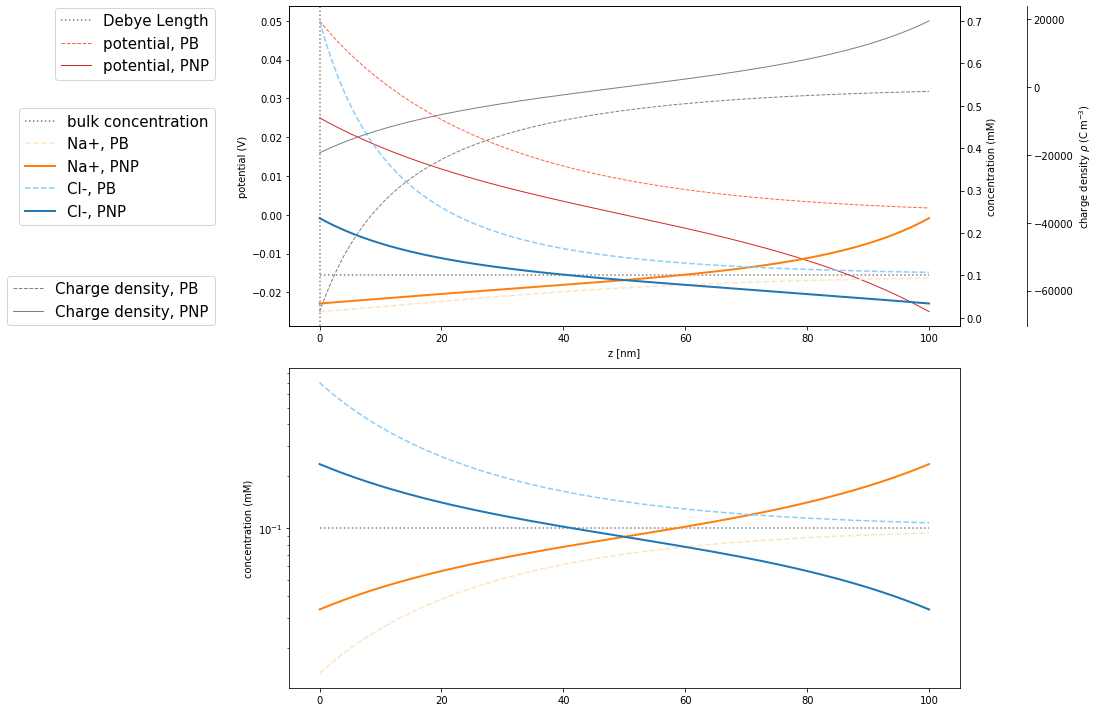

In [59]:
# analytic Poisson-Boltzmann distribution and numerical solution to full Poisson-Nernst-Planck system
x = np.linspace(0,L,100)
phi = potential(x, c, z, delta_u) 
C =   concentration(x, c, z, delta_u)
rho = charge_density(x, c, z, delta_u) 
deb = debye(c, z)

fig, (ax1,ax4) = plt.subplots(nrows=2,ncols=1,figsize=[16,10])
ax1.axvline(x=deb, label='Debye Length', color='grey', linestyle=':')

ax1.plot(x/sc.nano, phi, marker='', color='tomato', label='potential, PB', linewidth=1, linestyle='--')
ax1.plot(pnp.grid/sc.nano, pnp.potential, marker='', color='tab:red', label='potential, PNP', linewidth=1, linestyle='-')

ax2 = ax1.twinx()
ax2.plot(x/sc.nano, np.ones(x.shape)*c[0], label='bulk concentration', color='grey', linestyle=':')
ax2.plot(x/sc.nano, C[0], marker='', color='bisque', label='Na+, PB',linestyle='--')
ax2.plot(pnp.grid/sc.nano, pnp.concentration[0], marker='', color='tab:orange', label='Na+, PNP', linewidth=2, linestyle='-')

ax2.plot(x/sc.nano, C[1], marker='', color='lightskyblue', label='Cl-, PB',linestyle='--')
ax2.plot(pnp.grid/sc.nano, pnp.concentration[1], marker='', color='tab:blue', label='Cl-, PNP', linewidth=2, linestyle='-')

ax3 = ax1.twinx()
# Offset the right spine of ax3.  The ticks and label have already been
# placed on the right by twinx above.
ax3.spines["right"].set_position(("axes", 1.1))
# Having been created by twinx, ax3 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(ax3)
# Second, show the right spine.
ax3.spines["right"].set_visible(True)

ax3.plot(x/sc.nano, rho, label='Charge density, PB', color='grey', linewidth=1, linestyle='--')
ax3.plot(pnp.grid/sc.nano, pnp.charge_density, label='Charge density, PNP', color='grey', linewidth=1, linestyle='-')

ax4.semilogy(x/sc.nano, np.ones(x.shape)*c[0], label='bulk concentration', color='grey', linestyle=':')
ax4.semilogy(x/sc.nano, C[0], marker='', color='bisque', label='Na+, PB',linestyle='--')
ax4.semilogy(pnp.grid/sc.nano, pnp.concentration[0], marker='', color='tab:orange', label='Na+, PNP', linewidth=2, linestyle='-')

ax4.semilogy(x/sc.nano, C[1], marker='', color='lightskyblue', label='Cl-, PB',linestyle='--')
ax4.semilogy(pnp.grid/sc.nano, pnp.concentration[1], marker='', color='tab:blue', label='Cl-, PNP', linewidth=2, linestyle='-')


ax1.set_xlabel('z [nm]')
ax1.set_ylabel('potential (V)')
ax2.set_ylabel('concentration (mM)')
ax3.set_ylabel(r'charge density $\rho \> (\mathrm{C}\> \mathrm{m}^{-3})$')
ax4.set_ylabel('concentration (mM)')

#fig.legend(loc='center')
ax1.legend(loc='upper right',  bbox_to_anchor=(-0.1,1.02), fontsize=15)
ax2.legend(loc='center right', bbox_to_anchor=(-0.1,0.5),  fontsize=15)
ax3.legend(loc='lower right',  bbox_to_anchor=(-0.1,-0.02), fontsize=15)

fig.tight_layout()
plt.show()

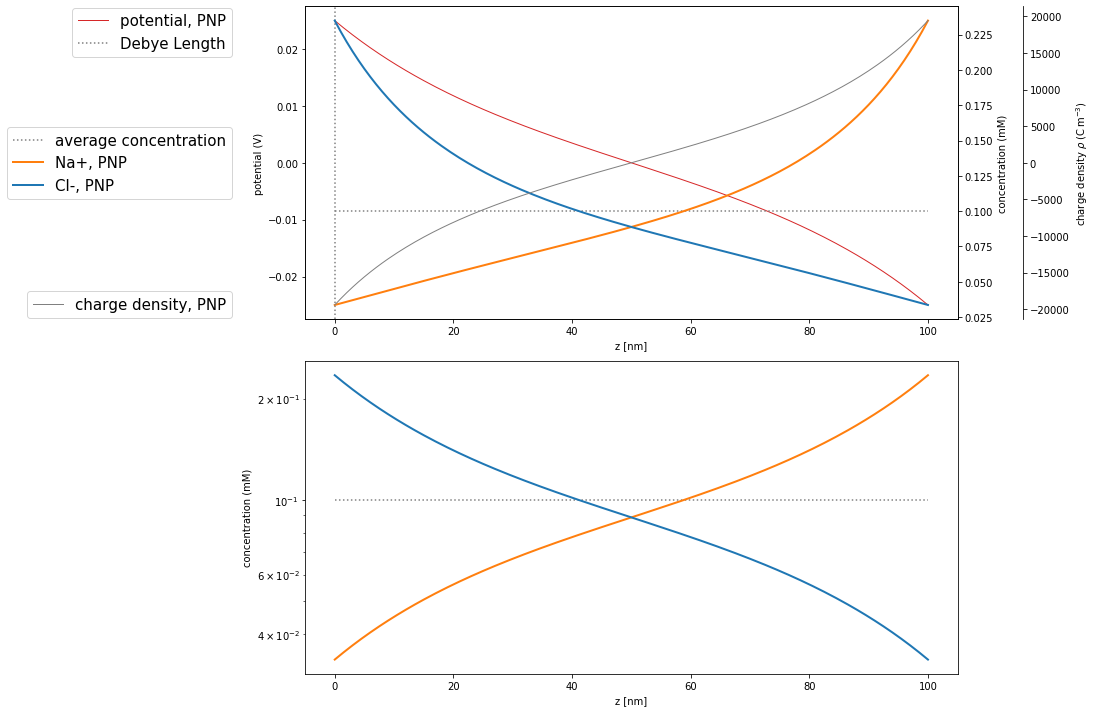

In [60]:
# analytic Poisson-Boltzmann distribution and numerical solution to full Poisson-Nernst-Planck system
x = np.linspace(0,L,100)

deb = debye(c, z)

fig, (ax1,ax4) = plt.subplots(nrows=2,ncols=1,figsize=[16,10])
ax1.set_xlabel('z [nm]')
ax1.plot(pnp.grid/sc.nano, pnp.potential, marker='', color='tab:red', label='potential, PNP', linewidth=1, linestyle='-')

ax2 = ax1.twinx()
ax2.plot(x/sc.nano, np.ones(x.shape)*c[0], label='average concentration', color='grey', linestyle=':')
ax2.plot(pnp.grid/sc.nano, pnp.concentration[0], marker='', color='tab:orange', label='Na+, PNP', linewidth=2, linestyle='-')

ax2.plot(pnp.grid/sc.nano, pnp.concentration[1], marker='', color='tab:blue', label='Cl-, PNP', linewidth=2, linestyle='-')
ax1.axvline(x=deb, label='Debye Length', color='grey', linestyle=':')

ax3 = ax1.twinx()
# Offset the right spine of ax3.  The ticks and label have already been
# placed on the right by twinx above.
ax3.spines["right"].set_position(("axes", 1.1))
# Having been created by twinx, ax3 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(ax3)
# Second, show the right spine.
ax3.spines["right"].set_visible(True)
ax3.plot(pnp.grid/sc.nano, pnp.charge_density, label='charge density, PNP', color='grey', linewidth=1, linestyle='-')

ax4.semilogy(x/sc.nano, np.ones(x.shape)*c[0], label='average concentration', color='grey', linestyle=':')
ax4.semilogy(pnp.grid/sc.nano, pnp.concentration[0], marker='', color='tab:orange', label='Na+, PNP', linewidth=2, linestyle='-')
ax4.semilogy(pnp.grid/sc.nano, pnp.concentration[1], marker='', color='tab:blue', label='Cl-, PNP', linewidth=2, linestyle='-')

ax1.set_xlabel('z [nm]')
ax1.set_ylabel('potential (V)')
ax2.set_ylabel('concentration (mM)')
ax3.set_ylabel(r'charge density $\rho \> (\mathrm{C}\> \mathrm{m}^{-3})$')
ax4.set_xlabel('z [nm]')
ax4.set_ylabel('concentration (mM)')

#fig.legend(loc='center')
ax1.legend(loc='upper right',  bbox_to_anchor=(-0.1,1.02), fontsize=15)
ax2.legend(loc='center right', bbox_to_anchor=(-0.1,0.5),  fontsize=15)
ax3.legend(loc='lower right',  bbox_to_anchor=(-0.1,-0.02), fontsize=15)

fig.tight_layout()
plt.show()

#### Potential at left and right hand side of domain

In [61]:
(pnp.potential[0],pnp.potential[-1])

(0.025, -0.025)

#### Residual cation flux at interfaces

In [62]:
( pnp.leftControlledVolumeSchemeFluxBC(pnp.xij1,0), pnp.rightControlledVolumeSchemeFluxBC(pnp.xij1,0) )

(-4.440892098500626e-16, -2.4868995751603507e-14)

#### Residual anion flux at interfaces

In [63]:
(pnp.leftControlledVolumeSchemeFluxBC(pnp.xij1,1),  pnp.rightControlledVolumeSchemeFluxBC(pnp.xij1,0) )

(3.552713678800501e-15, -2.4868995751603507e-14)

#### Cation concentration at interfaces

In [64]:
(pnp.concentration[0,0],pnp.concentration[0,-1])

(0.033557351099669806, 0.23494305672666177)

#### Anion concentration at interfaces

In [65]:
(pnp.concentration[1,0],pnp.concentration[1,-1])

(0.23494305672664342, 0.033557351099670576)

#### Equilibrium cation and anion amount

In [66]:
( pnp.numberConservationConstraint(pnp.xij1,0,0), pnp.numberConservationConstraint(pnp.xij1,1,0) )

(3.2768297950438363, 3.276829795043838)

#### Initial cation and anion amount

In [67]:
( pnp.numberConservationConstraint(pnp.xi0,0,0), pnp.numberConservationConstraint(pnp.xi0,1,0) )

(3.276829795043838, 3.276829795043838)

#### Species conservation

In [68]:
(pnp.numberConservationConstraint(pnp.xij1,0,
                                 pnp.numberConservationConstraint(pnp.xi0,0,0)), 
 pnp.numberConservationConstraint(pnp.xij1,1,
                                 pnp.numberConservationConstraint(pnp.xi0,1,0)) )

(-1.7763568394002505e-15, 0.0)

## Test case 5: 1D electrochemical cell, 0.1 mM NaCl, positive potential u = 0.05 V, 100 nm domain, 0.5 nm compact layer

At high potentials or bulk concentrations, pure PNP systems yield unphysically high concentrations and steep gradients close to the boundary, as an ion's finite size is not accounted for.
In addition, high gradients can lead to convergence issues. This problem can be alleviated by assuming a Stern layer (compact layer) at the interface. 
This compact layer is parametrized by its thickness $\lambda_S$ and can be treated explicitly by prescribing a linear potential regime across the compact layer region, or by 
the implicit parametrization of a compact layer with uniform charge density as Robin boundary conditions on the potential. 

In [69]:
c        = [1000,1000] # high concentrations close to NaCl's solubility limit in water
delta_u  = 0.05
L        = 30e-10 # tiny gap of 3 nm
lambda_S =  5e-10 # 0.5 nm Stern layer

In [70]:
pnp_no_compact_layer = PoissonNernstPlanckSystem(c,z,L,delta_u=delta_u, e=1e-12)

[ poisson_nernst_planck_solver.py:1004 - __init__() ]: ion species 00 concentration c               1000
[ poisson_nernst_planck_solver.py:1006 - __init__() ]: ion species 00 number charge z                  1
[ poisson_nernst_planck_solver.py:1004 - __init__() ]: ion species 01 concentration c               1000
[ poisson_nernst_planck_solver.py:1006 - __init__() ]: ion species 01 number charge z                 -1
[ poisson_nernst_planck_solver.py:1009 - __init__() ]: temperature T                               298.1
[ poisson_nernst_planck_solver.py:1011 - __init__() ]: domain size L                               3e-09
[ poisson_nernst_planck_solver.py:1013 - __init__() ]: compact layer thickness lambda_S                0
[ poisson_nernst_planck_solver.py:1015 - __init__() ]: reference position x0                           0
[ poisson_nernst_planck_solver.py:1017 - __init__() ]: potential difference delta_u                 0.05
[ poisson_nernst_planck_solver.py:1019 - __init__() ]: 

In [71]:
pnp_with_explicit_compact_layer = PoissonNernstPlanckSystem(c,z,L, delta_u=delta_u,lambda_S=lambda_S, e=1e-12)

[ poisson_nernst_planck_solver.py:1004 - __init__() ]: ion species 00 concentration c               1000
[ poisson_nernst_planck_solver.py:1006 - __init__() ]: ion species 00 number charge z                  1
[ poisson_nernst_planck_solver.py:1004 - __init__() ]: ion species 01 concentration c               1000
[ poisson_nernst_planck_solver.py:1006 - __init__() ]: ion species 01 number charge z                 -1
[ poisson_nernst_planck_solver.py:1009 - __init__() ]: temperature T                               298.1
[ poisson_nernst_planck_solver.py:1011 - __init__() ]: domain size L                               3e-09
[ poisson_nernst_planck_solver.py:1013 - __init__() ]: compact layer thickness lambda_S            5e-10
[ poisson_nernst_planck_solver.py:1015 - __init__() ]: reference position x0                           0
[ poisson_nernst_planck_solver.py:1017 - __init__() ]: potential difference delta_u                 0.05
[ poisson_nernst_planck_solver.py:1019 - __init__() ]: 

In [72]:
pnp_with_implicit_compact_layer = PoissonNernstPlanckSystem(c,z,L, delta_u=delta_u,lambda_S=lambda_S, e=1e-12)

[ poisson_nernst_planck_solver.py:1004 - __init__() ]: ion species 00 concentration c               1000
[ poisson_nernst_planck_solver.py:1006 - __init__() ]: ion species 00 number charge z                  1
[ poisson_nernst_planck_solver.py:1004 - __init__() ]: ion species 01 concentration c               1000
[ poisson_nernst_planck_solver.py:1006 - __init__() ]: ion species 01 number charge z                 -1
[ poisson_nernst_planck_solver.py:1009 - __init__() ]: temperature T                               298.1
[ poisson_nernst_planck_solver.py:1011 - __init__() ]: domain size L                               3e-09
[ poisson_nernst_planck_solver.py:1013 - __init__() ]: compact layer thickness lambda_S            5e-10
[ poisson_nernst_planck_solver.py:1015 - __init__() ]: reference position x0                           0
[ poisson_nernst_planck_solver.py:1017 - __init__() ]: potential difference delta_u                 0.05
[ poisson_nernst_planck_solver.py:1019 - __init__() ]: 

In [73]:
pnp_no_compact_layer.useStandardCellBC()

[ poisson_nernst_planck_solver.py:403 - useStandardCellBC() ]: Left hand side Dirichlet boundary condition u0 =  0.973  
[ poisson_nernst_planck_solver.py:405 - useStandardCellBC() ]: Right hand side Dirichlet boundary condition u1 = -0.973  
[ poisson_nernst_planck_solver.py:414 - useStandardCellBC() ]: Ion species 00 left hand side concentration Flux boundary condition j0 = 0       
[ poisson_nernst_planck_solver.py:417 - useStandardCellBC() ]: Ion species 00 number conservation constraint N0 = 9.83    
[ poisson_nernst_planck_solver.py:414 - useStandardCellBC() ]: Ion species 01 left hand side concentration Flux boundary condition j0 = 0       
[ poisson_nernst_planck_solver.py:417 - useStandardCellBC() ]: Ion species 01 number conservation constraint N0 = 9.83    


In [74]:
pnp_with_explicit_compact_layer.useSternLayerCellBC(implicit=False)

[ poisson_nernst_planck_solver.py:468 - useSternLayerCellBC() ]: Explicitly treating Stern layer as uniformly charged regions
[ poisson_nernst_planck_solver.py:475 - useSternLayerCellBC() ]: Left hand side Dirichlet boundary condition u0 =  0.973  
[ poisson_nernst_planck_solver.py:477 - useSternLayerCellBC() ]: Right hand side Dirichlet boundary condition u1 = -0.973  
[ poisson_nernst_planck_solver.py:487 - useSternLayerCellBC() ]: Ion species 00 left hand side concentration Flux boundary condition j0 = 0       
[ poisson_nernst_planck_solver.py:490 - useSternLayerCellBC() ]: Ion species 00 number conservation constraint N0 = 9.83    
[ poisson_nernst_planck_solver.py:487 - useSternLayerCellBC() ]: Ion species 01 left hand side concentration Flux boundary condition j0 = 0       
[ poisson_nernst_planck_solver.py:490 - useSternLayerCellBC() ]: Ion species 01 number conservation constraint N0 = 9.83    


In [75]:
pnp_with_implicit_compact_layer.useSternLayerCellBC(implicit=True)

[ poisson_nernst_planck_solver.py:444 - useSternLayerCellBC() ]: Implicitly treating Stern layer via Robin BC
[ poisson_nernst_planck_solver.py:455 - useSternLayerCellBC() ]: reduced cropped domain size L*              6.554
[ poisson_nernst_planck_solver.py:457 - useSternLayerCellBC() ]: shifted reduced reference position x0*      1.638
[ poisson_nernst_planck_solver.py:460 - useSternLayerCellBC() ]:  Left hand side Robin boundary condition u0 + lambda_S*dudx =  0.973  
[ poisson_nernst_planck_solver.py:462 - useSternLayerCellBC() ]: Right hand side Robin boundary condition u1 + lambda_S*dudx = -0.973  
[ poisson_nernst_planck_solver.py:487 - useSternLayerCellBC() ]: Ion species 00 left hand side concentration Flux boundary condition j0 = 0       
[ poisson_nernst_planck_solver.py:490 - useSternLayerCellBC() ]: Ion species 00 number conservation constraint N0 = 6.554   
[ poisson_nernst_planck_solver.py:487 - useSternLayerCellBC() ]: Ion species 01 left hand side concentration Flux bo

In [76]:
pnp_no_compact_layer.init()

[ poisson_nernst_planck_solver.py:269 - init() ]: discretization segments N                     200
[ poisson_nernst_planck_solver.py:271 - init() ]: grid points N                                 201
[ poisson_nernst_planck_solver.py:286 - init() ]: dx                                        0.04915
[ poisson_nernst_planck_solver.py:288 - init() ]: dx2overtau                                     10


In [77]:
pnp_with_explicit_compact_layer.init()

[ poisson_nernst_planck_solver.py:269 - init() ]: discretization segments N                     200
[ poisson_nernst_planck_solver.py:271 - init() ]: grid points N                                 201
[ poisson_nernst_planck_solver.py:286 - init() ]: dx                                        0.04915
[ poisson_nernst_planck_solver.py:288 - init() ]: dx2overtau                                     10


In [78]:
pnp_with_implicit_compact_layer.init()

[ poisson_nernst_planck_solver.py:269 - init() ]: discretization segments N                     200
[ poisson_nernst_planck_solver.py:271 - init() ]: grid points N                                 201
[ poisson_nernst_planck_solver.py:286 - init() ]: dx                                        0.03277
[ poisson_nernst_planck_solver.py:288 - init() ]: dx2overtau                                     10


In [79]:
pnp_no_compact_layer.output = True
xij_no_compact_layer = pnp_no_compact_layer.solve()

[ poisson_nernst_planck_solver.py:166 - newton() ]: Convergence criterion: norm(dx) < 1.00e-12
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    0: norm(dx)/norm(x) = 3.60e-01, norm(dx) = 7.77e+00, norm(F) = 1.38e-02
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    1: norm(dx)/norm(x) = 5.59e-02, norm(dx) = 1.20e+00, norm(F) = 5.22e-02
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    2: norm(dx)/norm(x) = 1.59e-04, norm(dx) = 3.45e-03, norm(F) = 5.09e-04
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    3: norm(dx)/norm(x) = 8.06e-07, norm(dx) = 1.75e-05, norm(F) = 7.21e-06
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    4: norm(dx)/norm(x) = 6.21e-08, norm(dx) = 1.35e-06, norm(F) = 3.19e-06
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    5: norm(dx)/norm(x) = 3.16e-09, norm(dx) = 6.86e-08, norm(F) = 1.59e-07
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    6: norm(dx)/norm(x) = 1.37e-10, norm(dx) = 2.96e-09, 

In [80]:
pnp_with_explicit_compact_layer.output = True
xij_with_explicit_compact_layer = pnp_with_explicit_compact_layer.solve()

[ poisson_nernst_planck_solver.py:166 - newton() ]: Convergence criterion: norm(dx) < 1.00e-12
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    0: norm(dx)/norm(x) = 4.11e-01, norm(dx) = 8.88e+00, norm(F) = 1.38e-02
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    1: norm(dx)/norm(x) = 4.77e-02, norm(dx) = 1.08e+00, norm(F) = 2.25e-02
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    2: norm(dx)/norm(x) = 1.48e-04, norm(dx) = 3.36e-03, norm(F) = 6.56e-05
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    3: norm(dx)/norm(x) = 7.80e-07, norm(dx) = 1.77e-05, norm(F) = 2.20e-06
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    4: norm(dx)/norm(x) = 7.11e-08, norm(dx) = 1.62e-06, norm(F) = 3.97e-07
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    5: norm(dx)/norm(x) = 3.03e-10, norm(dx) = 6.88e-09, norm(F) = 1.61e-08
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    6: norm(dx)/norm(x) = 1.46e-11, norm(dx) = 3.31e-10, 

In [81]:
pnp_with_implicit_compact_layer.output = True
xij_with_implicit_compact_layer = pnp_with_implicit_compact_layer.solve()

[ poisson_nernst_planck_solver.py:166 - newton() ]: Convergence criterion: norm(dx) < 1.00e-12
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    0: norm(dx)/norm(x) = 3.10e-01, norm(dx) = 6.69e+00, norm(F) = 6.88e-01
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    1: norm(dx)/norm(x) = 1.27e-02, norm(dx) = 2.58e-01, norm(F) = 1.35e-03
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    2: norm(dx)/norm(x) = 3.86e-05, norm(dx) = 7.85e-04, norm(F) = 7.53e-06
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    3: norm(dx)/norm(x) = 2.44e-07, norm(dx) = 4.97e-06, norm(F) = 1.67e-05
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    4: norm(dx)/norm(x) = 9.02e-08, norm(dx) = 1.84e-06, norm(F) = 4.41e-06
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    5: norm(dx)/norm(x) = 2.97e-09, norm(dx) = 6.05e-08, norm(F) = 1.38e-07
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    6: norm(dx)/norm(x) = 9.67e-11, norm(dx) = 1.97e-09, 

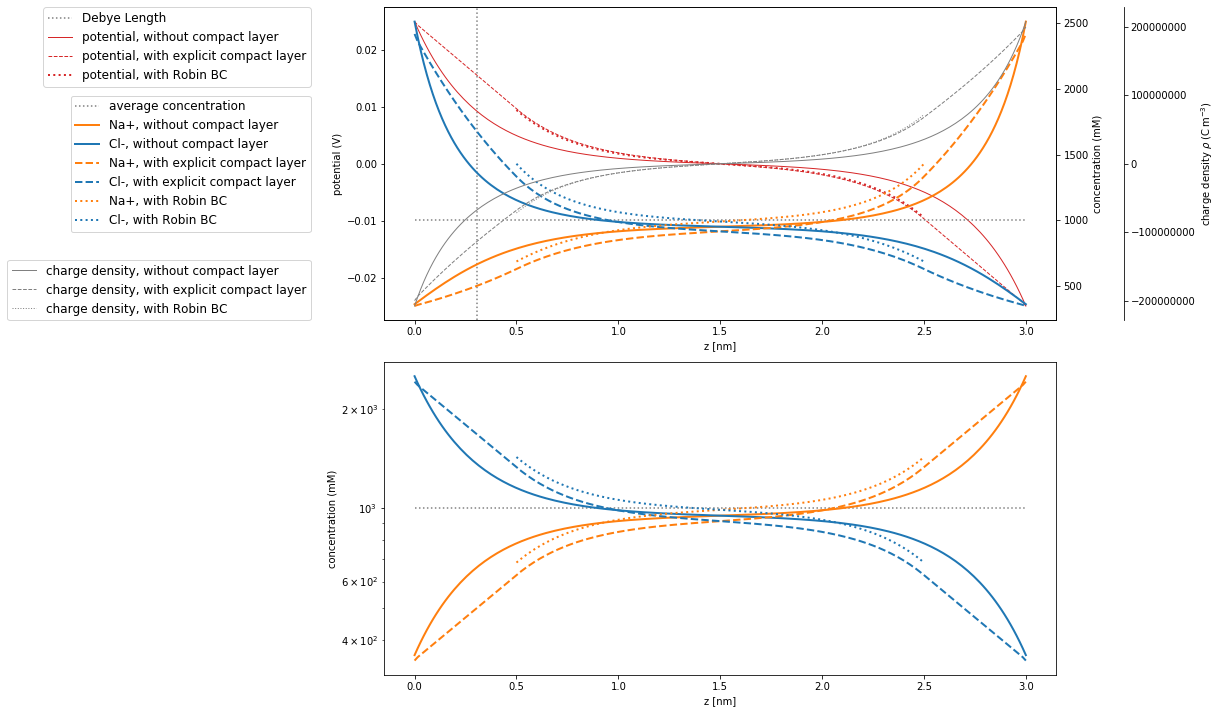

In [82]:
x = np.linspace(0,L,100)

deb = debye(c, z)

fig, (ax1,ax4) = plt.subplots(nrows=2,ncols=1,figsize=[18,10])

# 1 - potentials
ax1.axvline(x=deb/sc.nano, label='Debye Length', color='grey', linestyle=':')
ax1.plot(pnp_no_compact_layer.grid/sc.nano, pnp_no_compact_layer.potential, marker='', color='tab:red', label='potential, without compact layer', linewidth=1, linestyle='-')
ax1.plot(pnp_with_explicit_compact_layer.grid/sc.nano, pnp_with_explicit_compact_layer.potential, marker='', color='tab:red', label='potential, with explicit compact layer', linewidth=1, linestyle='--')
ax1.plot(pnp_with_implicit_compact_layer.grid/sc.nano, pnp_with_implicit_compact_layer.potential, marker='', color='tab:red', label='potential, with Robin BC', linewidth=2, linestyle=':')

# 2 - conencentratiosn
ax2 = ax1.twinx()
ax2.plot(x/sc.nano, np.ones(x.shape)*c[0], label='average concentration', color='grey', linestyle=':')

ax2.plot(pnp_no_compact_layer.grid/sc.nano, pnp_no_compact_layer.concentration[0], marker='', color='tab:orange', label='Na+, without compact layer', linewidth=2, linestyle='-')
ax2.plot(pnp_no_compact_layer.grid/sc.nano, pnp_no_compact_layer.concentration[1], marker='', color='tab:blue', label='Cl-, without compact layer', linewidth=2, linestyle='-')

ax2.plot(pnp_with_explicit_compact_layer.grid/sc.nano, pnp_with_explicit_compact_layer.concentration[0], marker='', color='tab:orange', label='Na+, with explicit compact layer', linewidth=2, linestyle='--')
ax2.plot(pnp_with_explicit_compact_layer.grid/sc.nano, pnp_with_explicit_compact_layer.concentration[1], marker='', color='tab:blue', label='Cl-, with explicit compact layer', linewidth=2, linestyle='--')

ax2.plot(pnp_with_implicit_compact_layer.grid/sc.nano, pnp_with_implicit_compact_layer.concentration[0], marker='', color='tab:orange', label='Na+, with Robin BC', linewidth=2, linestyle=':')
ax2.plot(pnp_with_implicit_compact_layer.grid/sc.nano, pnp_with_implicit_compact_layer.concentration[1], marker='', color='tab:blue', label='Cl-, with Robin BC', linewidth=2, linestyle=':')

# 3 - charge densities
ax3 = ax1.twinx()
# Offset the right spine of ax3.  The ticks and label have already been
# placed on the right by twinx above.
ax3.spines["right"].set_position(("axes", 1.1))
# Having been created by twinx, ax3 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(ax3)
# Second, show the right spine.
ax3.spines["right"].set_visible(True)
ax3.plot(pnp_no_compact_layer.grid/sc.nano, pnp_no_compact_layer.charge_density, label='charge density, without compact layer', color='grey', linewidth=1, linestyle='-')
ax3.plot(pnp_with_explicit_compact_layer.grid/sc.nano, pnp_with_explicit_compact_layer.charge_density, label='charge density, with explicit compact layer', color='grey', linewidth=1, linestyle='--')
ax3.plot(pnp_with_implicit_compact_layer.grid/sc.nano, pnp_with_implicit_compact_layer.charge_density, label='charge density, with Robin BC', color='grey', linewidth=1, linestyle=':')

# 4 - concentrations, semi log
ax4.semilogy(x/sc.nano, np.ones(x.shape)*c[0], label='average concentration', color='grey', linestyle=':')

ax4.semilogy(pnp_no_compact_layer.grid/sc.nano, pnp_no_compact_layer.concentration[0], marker='', color='tab:orange', label='Na+, without compact layer', linewidth=2, linestyle='-')
ax4.semilogy(pnp_no_compact_layer.grid/sc.nano, pnp_no_compact_layer.concentration[1], marker='', color='tab:blue', label='Cl-, without compact layer', linewidth=2, linestyle='-')

ax4.semilogy(pnp_with_explicit_compact_layer.grid/sc.nano, pnp_with_explicit_compact_layer.concentration[0], marker='', color='tab:orange', label='Na+, with explicit compact layer', linewidth=2, linestyle='--')
ax4.semilogy(pnp_with_explicit_compact_layer.grid/sc.nano, pnp_with_explicit_compact_layer.concentration[1], marker='', color='tab:blue', label='Cl-, with explicit compact layer', linewidth=2, linestyle='--')

ax4.semilogy(pnp_with_implicit_compact_layer.grid/sc.nano, pnp_with_implicit_compact_layer.concentration[0], marker='', color='tab:orange', label='Na+, with Robin BC', linewidth=2, linestyle=':')
ax4.semilogy(pnp_with_implicit_compact_layer.grid/sc.nano, pnp_with_implicit_compact_layer.concentration[1], marker='', color='tab:blue', label='Cl-, with Robin BC', linewidth=2, linestyle=':')

ax1.set_xlabel('z [nm]')
ax1.set_ylabel('potential (V)')
ax2.set_ylabel('concentration (mM)')
ax3.set_ylabel(r'charge density $\rho \> (\mathrm{C}\> \mathrm{m}^{-3})$')
#ax3.yaxis.set_major_formatter(formatter)
ax3.ticklabel_format(axis='y', style='sci', scilimits=(-2,10), useOffset=False, useMathText=False)
ax4.set_xlabel('z [nm]')
ax4.set_ylabel('concentration (mM)')

#fig.legend(loc='center')
ax1.legend(loc='upper right',  bbox_to_anchor=(-0.1,1.02), fontsize=12)
ax2.legend(loc='center right', bbox_to_anchor=(-0.1,0.5),  fontsize=12)
ax3.legend(loc='lower right',  bbox_to_anchor=(-0.1,-0.02), fontsize=12)

fig.tight_layout()
plt.show()

#### Potential at left and right hand side of domain

(pnp_no_compact_layer.potential[0],pnp_no_compact_layer.potential[-1])

(pnp_with_explicit_compact_layer.potential[0],pnp_with_explicit_compact_layer.potential[-1])

(pnp_with_implicit_compact_layer.potential[0],pnp_with_implicit_compact_layer.potential[-1])

#### Residual cation flux at interfaces

( pnp_no_compact_layer.leftControlledVolumeSchemeFluxBC(pnp_no_compact_layer.xij1,0), pnp_no_compact_layer.rightControlledVolumeSchemeFluxBC(pnp_no_compact_layer.xij1,0) )

( pnp_with_explicit_compact_layer.leftControlledVolumeSchemeFluxBC(pnp_with_explicit_compact_layer.xij1,0), pnp_with_explicit_compact_layer.rightControlledVolumeSchemeFluxBC(pnp_with_explicit_compact_layer.xij1,0) )

( pnp_with_implicit_compact_layer.leftControlledVolumeSchemeFluxBC(pnp_with_implicit_compact_layer.xij1,0), pnp_with_implicit_compact_layer.rightControlledVolumeSchemeFluxBC(pnp_with_implicit_compact_layer.xij1,0) )

#### Residual cation flux at interfaces

( pnp_no_compact_layer.leftControlledVolumeSchemeFluxBC(pnp_no_compact_layer.xij1,1), pnp_no_compact_layer.rightControlledVolumeSchemeFluxBC(pnp_no_compact_layer.xij1,1) )

( pnp_with_explicit_compact_layer.leftControlledVolumeSchemeFluxBC(pnp_with_explicit_compact_layer.xij1,1), pnp_with_explicit_compact_layer.rightControlledVolumeSchemeFluxBC(pnp_with_explicit_compact_layer.xij1,1) )

( pnp_with_implicit_compact_layer.leftControlledVolumeSchemeFluxBC(pnp_with_implicit_compact_layer.xij1,1), pnp_with_implicit_compact_layer.rightControlledVolumeSchemeFluxBC(pnp_with_implicit_compact_layer.xij1,1) )

#### Cation concentration at interfaces

(pnp_no_compact_layer.concentration[0,0],pnp_no_compact_layer.concentration[0,-1])

(pnp_with_explicit_compact_layer.concentration[0,0],pnp_with_explicit_compact_layer.concentration[0,-1])

(pnp_with_implicit_compact_layer.concentration[0,0],pnp_with_implicit_compact_layer.concentration[0,-1])

#### Anion concentration at interfaces
L
(pnp_no_compact_layer.concentration[1,0],pnp_no_compact_layer.concentration[1,-1])

(pnp_with_explicit_compact_layer.concentration[1,0],pnp_with_explicit_compact_layer.concentration[1,-1])

(pnp_with_implicit_compact_layer.concentration[1,0],pnp_with_implicit_compact_layer.concentration[1,-1])

#### Equilibrium cation and anion amount

( pnp_no_compact_layer.numberConservationConstraint(pnp_no_compact_layer.xij1,0,0), pnp_no_compact_layer.numberConservationConstraint(pnp_no_compact_layer.xij1,1,0) )

( pnp_with_explicit_compact_layer.numberConservationConstraint(pnp_with_explicit_compact_layer.xij1,0,0), pnp_with_explicit_compact_layer.numberConservationConstraint(pnp_with_explicit_compact_layer.xij1,1,0) )

( pnp_with_implicit_compact_layer.numberConservationConstraint(pnp_with_implicit_compact_layer.xij1,0,0), pnp_with_implicit_compact_layer.numberConservationConstraint(pnp_with_implicit_compact_layer.xij1,1,0) )

#### Initial cation and anion amount

( pnp_no_compact_layer.numberConservationConstraint(pnp_no_compact_layer.xi0,0,0), pnp_no_compact_layer.numberConservationConstraint(pnp_no_compact_layer.xi0,1,0) )

( pnp_with_explicit_compact_layer.numberConservationConstraint(pnp_with_explicit_compact_layer.xi0,0,0), pnp_with_explicit_compact_layer.numberConservationConstraint(pnp_with_explicit_compact_layer.xi0,1,0) )

( pnp_with_implicit_compact_layer.numberConservationConstraint(pnp_with_implicit_compact_layer.xi0,0,0), pnp_with_implicit_compact_layer.numberConservationConstraint(pnp_with_implicit_compact_layer.xi0,1,0) )

#### Species conservation

(pnp_no_compact_layer.numberConservationConstraint(pnp_no_compact_layer.xij1,0,
                                 pnp_no_compact_layer.numberConservationConstraint(pnp_no_compact_layer.xi0,0,0)), 
 pnp_no_compact_layer.numberConservationConstraint(pnp_no_compact_layer.xij1,1,
                                 pnp_no_compact_layer.numberConservationConstraint(pnp_no_compact_layer.xi0,1,0)) )

(pnp_with_explicit_compact_layer.numberConservationConstraint(pnp_with_explicit_compact_layer.xij1,0,
                                 pnp_with_explicit_compact_layer.numberConservationConstraint(pnp_with_explicit_compact_layer.xi0,0,0)), 
 pnp_with_explicit_compact_layer.numberConservationConstraint(pnp_with_explicit_compact_layer.xij1,1,
                                 pnp_with_explicit_compact_layer.numberConservationConstraint(pnp_with_explicit_compact_layer.xi0,1,0)) )

(pnp_with_implicit_compact_layer.numberConservationConstraint(pnp_with_implicit_compact_layer.xij1,0,
                                 pnp_with_implicit_compact_layer.numberConservationConstraint(pnp_with_implicit_compact_layer.xi0,0,0)), 
 pnp_with_implicit_compact_layer.numberConservationConstraint(pnp_with_implicit_compact_layer.xij1,1,
                                 pnp_with_implicit_compact_layer.numberConservationConstraint(pnp_with_implicit_compact_layer.xi0,1,0)) )

## Sample application of 1D electrochemical cell model:

We want to fill a gap of 3 nm between gold electrodes with 0.2 wt % NaCl aqueous solution, apply a small potential difference and generate an initial configuration for LAMMPS within a cubic box:

In [107]:
box_Ang=np.array([50.,50.,50.]) # Angstrom

In [108]:
box_m = box_Ang*sc.angstrom

In [109]:
box_m

array([5.e-09, 5.e-09, 5.e-09])

In [110]:
vol_AngCube = box_Ang.prod() # Angstrom^3

In [111]:
vol_mCube = vol_AngCube*sc.angstrom**3

With a concentration of 0.2 wt %, we are close to NaCl's solubility limit in water.
We estimate molar concentrations and atom numbers in our box:

In [112]:
# enter number between 0 ... 0.2 
weight_concentration_NaCl = 0.2 # wt %
# calculate saline mass density g/cm³
saline_mass_density_kg_per_L  = 1 + weight_concentration_NaCl * 0.15 / 0.20 # g / cm^3, kg / L
# see https://www.engineeringtoolbox.com/density-aqueous-solution-inorganic-sodium-salt-concentration-d_1957.html

In [113]:
saline_mass_density_g_per_L = saline_mass_density_kg_per_L*sc.kilo

In [114]:
molar_mass_H2O = 18.015 # g / mol
molar_mass_NaCl  = 58.44 # g / mol

In [115]:
cNaCl_M = weight_concentration_NaCl*saline_mass_density_g_per_L/molar_mass_NaCl # mol L^-1

In [116]:
cNaCl_mM = np.round(cNaCl_M/sc.milli) # mM

In [117]:
cNaCl_mM

3936.0

In [118]:
n_NaCl = np.round(cNaCl_mM*vol_mCube*sc.value('Avogadro constant'))

In [119]:
n_NaCl

296.0

In [120]:
c = [cNaCl_mM,cNaCl_mM]
z = [1,-1]
L=box_m[2]
lamda_S = 2.0e-10
delta_u  = 0.5

In [121]:
pnp = PoissonNernstPlanckSystem(c,z,L, lambda_S=lambda_S, delta_u=delta_u, N=200, maxit=20, e=1e-6)

[ poisson_nernst_planck_solver.py:1004 - __init__() ]: ion species 00 concentration c               3936
[ poisson_nernst_planck_solver.py:1006 - __init__() ]: ion species 00 number charge z                  1
[ poisson_nernst_planck_solver.py:1004 - __init__() ]: ion species 01 concentration c               3936
[ poisson_nernst_planck_solver.py:1006 - __init__() ]: ion species 01 number charge z                 -1
[ poisson_nernst_planck_solver.py:1009 - __init__() ]: temperature T                               298.1
[ poisson_nernst_planck_solver.py:1011 - __init__() ]: domain size L                               5e-09
[ poisson_nernst_planck_solver.py:1013 - __init__() ]: compact layer thickness lambda_S            5e-10
[ poisson_nernst_planck_solver.py:1015 - __init__() ]: reference position x0                           0
[ poisson_nernst_planck_solver.py:1017 - __init__() ]: potential difference delta_u                  0.5
[ poisson_nernst_planck_solver.py:1019 - __init__() ]: 

In [122]:
pnp.useSternLayerCellBC()

[ poisson_nernst_planck_solver.py:468 - useSternLayerCellBC() ]: Explicitly treating Stern layer as uniformly charged regions
[ poisson_nernst_planck_solver.py:475 - useSternLayerCellBC() ]: Left hand side Dirichlet boundary condition u0 =  9.73   
[ poisson_nernst_planck_solver.py:477 - useSternLayerCellBC() ]: Right hand side Dirichlet boundary condition u1 = -9.73   
[ poisson_nernst_planck_solver.py:487 - useSternLayerCellBC() ]: Ion species 00 left hand side concentration Flux boundary condition j0 = 0       
[ poisson_nernst_planck_solver.py:490 - useSternLayerCellBC() ]: Ion species 00 number conservation constraint N0 = 32.51   
[ poisson_nernst_planck_solver.py:487 - useSternLayerCellBC() ]: Ion species 01 left hand side concentration Flux boundary condition j0 = 0       
[ poisson_nernst_planck_solver.py:490 - useSternLayerCellBC() ]: Ion species 01 number conservation constraint N0 = 32.51   


In [123]:
pnp.init()

[ poisson_nernst_planck_solver.py:269 - init() ]: discretization segments N                     200
[ poisson_nernst_planck_solver.py:271 - init() ]: grid points N                                 201
[ poisson_nernst_planck_solver.py:286 - init() ]: dx                                         0.1625
[ poisson_nernst_planck_solver.py:288 - init() ]: dx2overtau                                     10


In [124]:
pnp.output = True
xij = pnp.solve()

[ poisson_nernst_planck_solver.py:166 - newton() ]: Convergence criterion: norm(dx) < 1.00e-06
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    0: norm(dx)/norm(x) = 6.98e-01, norm(dx) = 5.76e+01, norm(F) = 1.54e-01
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    1: norm(dx)/norm(x) = 3.95e-01, norm(dx) = 3.40e+01, norm(F) = 3.60e+00
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    2: norm(dx)/norm(x) = 2.42e-02, norm(dx) = 2.60e+00, norm(F) = 3.78e-01
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    3: norm(dx)/norm(x) = 8.02e-04, norm(dx) = 8.48e-02, norm(F) = 4.47e-03
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    4: norm(dx)/norm(x) = 2.06e-06, norm(dx) = 2.18e-04, norm(F) = 9.42e-07
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    5: norm(dx)/norm(x) = 1.01e-08, norm(dx) = 1.07e-06, norm(F) = 5.37e-07
[ poisson_nernst_planck_solver.py:238 - newton() ]: Ended after 6 steps.


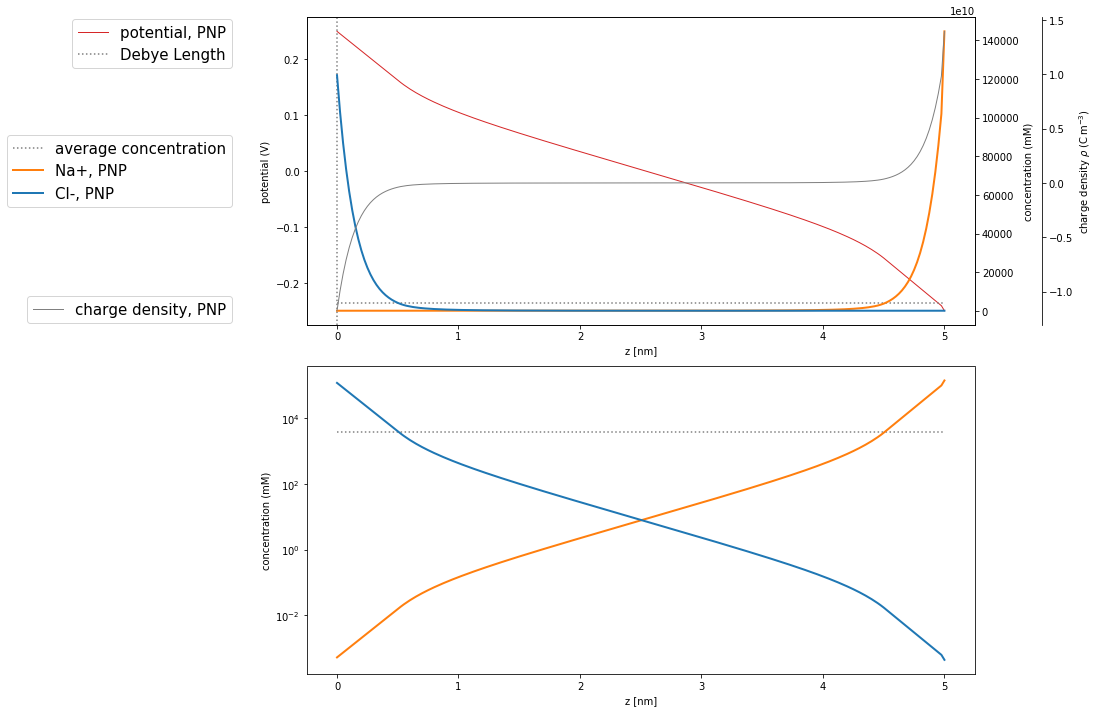

In [125]:
# analytic Poisson-Boltzmann distribution and numerical solution to full Poisson-Nernst-Planck system
x = np.linspace(0,L,100)

deb = debye(c, z)

fig, (ax1,ax4) = plt.subplots(nrows=2,ncols=1,figsize=[16,10])
ax1.set_xlabel('z [nm]')
ax1.plot(pnp.grid/sc.nano, pnp.potential, marker='', color='tab:red', label='potential, PNP', linewidth=1, linestyle='-')

ax2 = ax1.twinx()
ax2.plot(x/sc.nano, np.ones(x.shape)*c[0], label='average concentration', color='grey', linestyle=':')
ax2.plot(pnp.grid/sc.nano, pnp.concentration[0], marker='', color='tab:orange', label='Na+, PNP', linewidth=2, linestyle='-')

ax2.plot(pnp.grid/sc.nano, pnp.concentration[1], marker='', color='tab:blue', label='Cl-, PNP', linewidth=2, linestyle='-')
ax1.axvline(x=deb, label='Debye Length', color='grey', linestyle=':')

ax3 = ax1.twinx()
# Offset the right spine of ax3.  The ticks and label have already been
# placed on the right by twinx above.
ax3.spines["right"].set_position(("axes", 1.1))
# Having been created by twinx, ax3 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(ax3)
# Second, show the right spine.
ax3.spines["right"].set_visible(True)
ax3.plot(pnp.grid/sc.nano, pnp.charge_density, label='charge density, PNP', color='grey', linewidth=1, linestyle='-')

ax4.semilogy(x/sc.nano, np.ones(x.shape)*c[0], label='average concentration', color='grey', linestyle=':')
ax4.semilogy(pnp.grid/sc.nano, pnp.concentration[0], marker='', color='tab:orange', label='Na+, PNP', linewidth=2, linestyle='-')
ax4.semilogy(pnp.grid/sc.nano, pnp.concentration[1], marker='', color='tab:blue', label='Cl-, PNP', linewidth=2, linestyle='-')

ax1.set_xlabel('z [nm]')
ax1.set_ylabel('potential (V)')
ax2.set_ylabel('concentration (mM)')
ax3.set_ylabel(r'charge density $\rho \> (\mathrm{C}\> \mathrm{m}^{-3})$')
ax4.set_xlabel('z [nm]')
ax4.set_ylabel('concentration (mM)')

#fig.legend(loc='center')
ax1.legend(loc='upper right',  bbox_to_anchor=(-0.1,1.02), fontsize=15)
ax2.legend(loc='center right', bbox_to_anchor=(-0.1,0.5),  fontsize=15)
ax3.legend(loc='lower right',  bbox_to_anchor=(-0.1,-0.02), fontsize=15)

fig.tight_layout()
plt.show()

#### Potential at left and right hand side of domain

In [126]:
(pnp.potential[0],pnp.potential[-1])

(0.25, -0.25)

#### Residual cation flux at interfaces

In [127]:
( pnp.leftControlledVolumeSchemeFluxBC(pnp.xij1,0), pnp.rightControlledVolumeSchemeFluxBC(pnp.xij1,0) )

(-1.0587911840678754e-22, 1.0658141036401503e-14)

#### Residual anion flux at interfaces

In [128]:
(pnp.leftControlledVolumeSchemeFluxBC(pnp.xij1,1),  pnp.rightControlledVolumeSchemeFluxBC(pnp.xij1,0) )

(2.4868995751603507e-14, 1.0658141036401503e-14)

#### Cation concentration at interfaces

In [129]:
(pnp.concentration[0,0],pnp.concentration[0,-1])

(0.0005113593697388644, 144702.37133964463)

#### Anion concentration at interfaces

In [130]:
(pnp.concentration[1,0],pnp.concentration[1,-1])

(121993.60112769733, 0.00043110955468776235)

#### Equilibrium cation and anion amount

In [131]:
( pnp.numberConservationConstraint(pnp.xij1,0,0), pnp.numberConservationConstraint(pnp.xij1,1,0) )

(32.50509450777841, 32.50509450777909)

#### Initial cation and anion amount

In [132]:
( pnp.numberConservationConstraint(pnp.xi0,0,0), pnp.numberConservationConstraint(pnp.xi0,1,0) )

(32.505094507778395, 32.505094507778395)

#### Species conservation

In [133]:
(pnp.numberConservationConstraint(pnp.xij1,0,
                                 pnp.numberConservationConstraint(pnp.xi0,0,0)), 
 pnp.numberConservationConstraint(pnp.xij1,1,
                                 pnp.numberConservationConstraint(pnp.xi0,1,0)) )

(1.4210854715202004e-14, 6.963318810448982e-13)

## Sampling
First, convert the physical concentration distributions into a callable "probability density":

In [134]:
pnp.concentration.shape

(2, 201)

In [135]:
distributions = [interpolate.interp1d(pnp.grid,pnp.concentration[i,:]) for i in range(pnp.concentration.shape[0])]

Normalization is not necessary here. Now we can sample the distribution of our $Na^+$ ions in z-direction.

[ continuous2discrete.py:255 - generate_structure() ]: Using uniform distribution along x and y direction.
[ continuous2discrete.py:257 - generate_structure() ]: Using distribution <scipy.interpolate.interpolate.interp1d object at 0x7ff86ddba408> along z direction.
[ continuous2discrete.py:271 - generate_structure() ]: Using [nan nan nan] grid as sampling support.
[ continuous2discrete.py:289 - generate_structure() ]: Normalizing 'distribution' <function uniform at 0x7ff8754c1bf8> by 2.5e-09.
[ continuous2discrete.py:289 - generate_structure() ]: Normalizing 'distribution' <function uniform at 0x7ff8754c1bf8> by 2.5e-09.
[ continuous2discrete.py:289 - generate_structure() ]: Normalizing 'distribution' <scipy.interpolate.interpolate.interp1d object at 0x7ff86ddba408> by 1.7968760335485397e-05.
[ continuous2discrete.py:298 - generate_structure() ]: Drew (296, 3) samples from distributions.


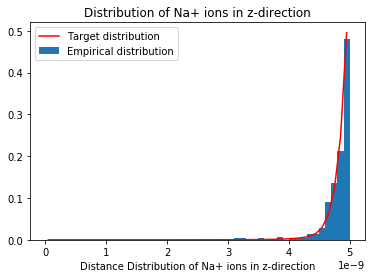

In [136]:
na_coordinate_sample = continuous2discrete(
    distribution=distributions[0], box=box_m, count=n_NaCl)
histx, histy, histz = get_histogram(na_coordinate_sample, box=box_m, n_bins=51)
plot_dist(histz, 'Distribution of Na+ ions in z-direction', reference_distribution=distributions[0])

[ continuous2discrete.py:255 - generate_structure() ]: Using uniform distribution along x and y direction.
[ continuous2discrete.py:257 - generate_structure() ]: Using distribution <scipy.interpolate.interpolate.interp1d object at 0x7ff86dd67778> along z direction.
[ continuous2discrete.py:271 - generate_structure() ]: Using [nan nan nan] grid as sampling support.
[ continuous2discrete.py:289 - generate_structure() ]: Normalizing 'distribution' <function uniform at 0x7ff8754c1bf8> by 2.5e-09.
[ continuous2discrete.py:289 - generate_structure() ]: Normalizing 'distribution' <function uniform at 0x7ff8754c1bf8> by 2.5e-09.
[ continuous2discrete.py:289 - generate_structure() ]: Normalizing 'distribution' <scipy.interpolate.interpolate.interp1d object at 0x7ff86dd67778> by 1.825316159340641e-05.
[ continuous2discrete.py:298 - generate_structure() ]: Drew (296, 3) samples from distributions.


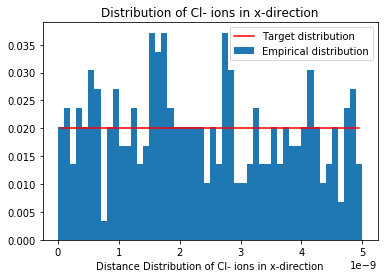

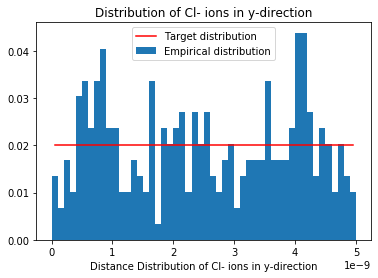

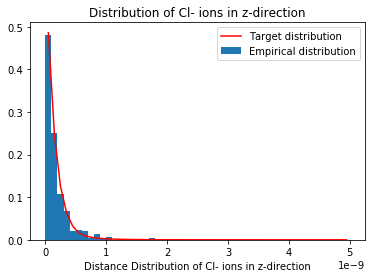

In [138]:
cl_coordinate_sample = continuous2discrete(
    distributions[1], box=box_m, count=n_NaCl)
histx, histy, histz = get_histogram(cl_coordinate_sample, box=box_m, n_bins=51)
plot_dist(histx, 'Distribution of Cl- ions in x-direction', reference_distribution=lambda x: np.ones(x.shape)*1/box_m[0])
plot_dist(histy, 'Distribution of Cl- ions in y-direction', reference_distribution=lambda x: np.ones(x.shape)*1/box_m[1])
plot_dist(histz, 'Distribution of Cl- ions in z-direction', reference_distribution=distributions[1])

## Write to file
To visualize our sampled coordinates, we utilize ASE to export it to some standard format, i.e. .xyz or LAMMPS data file.
ASE speaks Ångström per default, thus we convert SI units:

In [139]:
sample_size = int(n_NaCl)

In [140]:
sample_size

296

In [141]:
na_atoms = ase.Atoms(
    symbols='Na'*sample_size,
    charges=[1]*sample_size,
    positions=na_coordinate_sample/sc.angstrom,
    cell=box_Ang,
    pbc=[1,1,0])

cl_atoms = ase.Atoms(
    symbols='Cl'*sample_size,
    charges=[-1]*sample_size,
    positions=cl_coordinate_sample/sc.angstrom,
    cell=box_Ang,
    pbc=[1,1,0])

system = na_atoms + cl_atoms

system

ase.io.write('NaCl_c_4_M_u_0.5_V_box_5x5x10nm_lambda_S_2_Ang.xyz',system,format='xyz')

In [142]:
# LAMMPS data format, units 'real', atom style 'full'
# before ASE 3.19.0b1, ASE had issues with exporting atom style 'full' in LAMMPS data file format, so do not expect this line to work for older ASE versions
ase.io.write('NaCl_c_4_M_u_0.5_V_box_5x5x10nm_lambda_S_2_Ang.lammps',system,format='lammps-data',units="real",atom_style='full')